In [1]:
# Import libraries and dependencies
import pandas as pd
import requests
import matplotlib.pyplot as plt
import json
import scipy
import numpy as np
from sklearn import preprocessing
import math

from config import api_key

In [2]:
# Specify relative path
url = '/Users/mac/Downloads/yelp_dataset/'
path = 'https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input='
path2 = 'https://maps.googleapis.com/maps/api/place/textsearch/json?query='
n_input = 'strip+clubs+in+las+vegas'
input_type = '&inputtype=textquery'
fields = f'&fields=photos,formatted_address,name,rating,opening_hours'
key = f'&key={api_key}'

find_place = f'{path}{n_input}{input_type}{fields}{key}'
text_search = f'{path2}{n_input}{key}'
# Convert JSON to pandas DataFrame
data = pd.read_json(url + 'business.json', lines=True)
data_copy = data
response = requests.get(text_search)
response_json = response.json()
# Filter data by business of interest: Restaurants 
# restaurants_filter = data[data['categories'].str.contains("Restaurants") == True]
x = [x for x in response_json['results']]
l = []
for i in range(len(response_json)):
    l.append(response_json['results'][i]['formatted_address'])

# Display First 5 instances of the data
data.head()

address  \
0     2818 E Camino Acequia Drive   
1            30 Eglinton Avenue W   
2       10110 Johnston Rd, Ste 15   
3   15655 W Roosevelt St, Ste 237   
4  4209 Stuart Andrew Blvd, Ste F   

                                          attributes             business_id  \
0                           {'GoodForKids': 'False'}  1SWheh84yJXfytovILXOAQ   
1  {'RestaurantsReservations': 'True', 'GoodForMe...  QXAEGFB4oINsVuTFxEYKFQ   
2  {'GoodForKids': 'True', 'NoiseLevel': 'u'avera...  gnKjwL_1w79qoiV3IC_xQQ   
3                                               None  xvX2CttrVhyG2z1dFg_0xw   
4  {'BusinessAcceptsBitcoin': 'False', 'ByAppoint...  HhyxOkGAM07SRYtlQ4wMFQ   

                                          categories         city  \
0                                  Golf, Active Life      Phoenix   
1  Specialty Food, Restaurants, Dim Sum, Imported...  Mississauga   
2                  Sushi Bars, Restaurants, Japanese    Charlotte   
3                      Insurance, Financial Services     Goodyear   
4  Plumbing, Shopping, Local Services, Home Servi...    Charlotte   

                                               hours  is_open   latitude  \
0                                               None        0  33.522143   
1  {'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...        1  43.605499   
2  {'Monday': '17:30-21:30', 'Wednesday': '17:30-...        1  35.092564   
3  {'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...        1  33.455613   
4  {'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...        1  35.190012   

    longitude                             name postal_code  review_count  \
0 -112.018481       Arizona Biltmore Golf Club       85016             5   
1  -79.652289       Emerald Chinese Restaurant     L5R 3E7           128   
2  -80.859132      Musashi Japanese Restaurant       28210           170   
3 -112.395596  Farmers Insurance - Paul Lorenz       85338             3   
4  -80.887223              Queen City Plumbing       28217             4   

   stars state  
0    3.0    AZ  
1    2.5    ON  
2    4.0    NC  
3    5.0    AZ  
4    4.0    NC

In [3]:
# Get descriptive stats of the data
description = data.describe()
description

is_open       latitude      longitude   review_count  \
count  192609.000000  192609.000000  192609.000000  192609.000000   
mean        0.823040      38.541803     -97.594785      33.538962   
std         0.381635       4.941964      16.697725     110.135224   
min         0.000000      33.204642    -115.493471       3.000000   
25%         1.000000      33.637408    -112.274677       4.000000   
50%         1.000000      36.144815    -111.759323       9.000000   
75%         1.000000      43.602989     -79.983614      25.000000   
max         1.000000      51.299943     -72.911982    8348.000000   

               stars  
count  192609.000000  
mean        3.585627  
std         1.018458  
min         1.000000  
25%         3.000000  
50%         3.500000  
75%         4.500000  
max         5.000000

In [4]:
# Check for missing values
miss_values = data.isna().sum()

# Display missing values per column 
miss_values
# For general purpose analysis, the columns that contains missing values doesn't need to have your rows excluded
# Futher analysis however can filter those values if necessary

address             0
attributes      28836
business_id         0
categories        482
city                0
hours           44830
is_open             0
latitude            0
longitude           0
name                0
postal_code         0
review_count        0
stars               0
state               0
dtype: int64

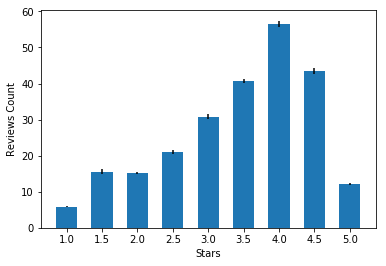

In [5]:
# Check the sparsity between reviews count and stars
    # Get the average reviews count per stars category
stars_group = data.groupby('stars').mean().reset_index() 

    # Get the SEM of reviews count per stars category
sem_stars_group = data.groupby('stars').sem().reset_index()

    # Plot error bar chart of the distribution of reviews count per star category
plt.bar(stars_group['stars'],
        stars_group['review_count'],
        yerr=sem_stars_group['review_count'],
        width=0.3,
        )
plt.xticks(stars_group['stars'])
plt.ylabel("Reviews Count")
plt.xlabel("Stars")
plt.show()

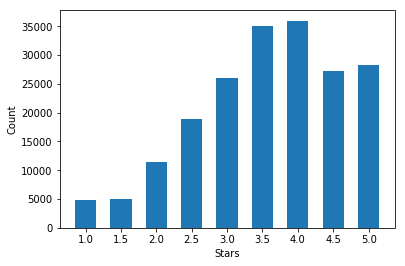

In [6]:
# Check for the distribution of observations by stars
count_stars = data.groupby('stars').count().reset_index()

plt.bar(stars_group['stars'],
        count_stars['review_count'],
        width=0.3,
        )
plt.xticks(stars_group['stars'])
plt.ylabel("Count")
plt.xlabel("Stars")
plt.show()

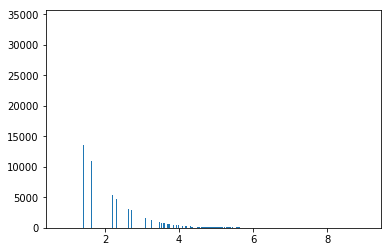

In [7]:
# Create a Key Performance Indicator for the "success" of a business in yelp
    # Slicing stars and reviews count
stars_df = data['stars']
lb = 1
log_reviews_count_array = np.log(data['review_count']*\
                                 data['review_count']/\
                                 (data['review_count']+lb))
# # log_reviews_count_array
#     # Normalize reviews_array
# norm_reviews_count = preprocessing.normalize([log_reviews_count_array])
# norm_reviews_count = norm_reviews_count[0]
plt.hist(log_reviews_count_array, bins=1000)
plt.show()

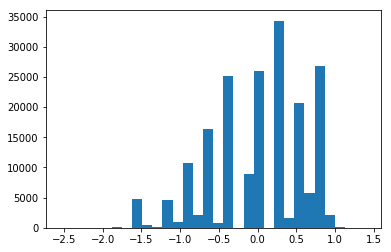

In [8]:
# Create column of KPI

score = []

for review in data['review_count']:
    # Until mean receive score 0.6
    if review <= 34:
        score.append(0.6)
    # Until mean + std dev receive score 0.7
    elif review <= 144:
        score.append(0.7)
    # Until mean + 2*std dev receive score 0.8
    elif review <= 254:
        score.append(0.8)
    # Until mean + 3*std dev receive score 0.9
    elif review <= 364:
        score.append(0.9)
    # Above mean + 3*std dev receive score 1.0
    else:
        score.append(1.0)

# Standardize stars column
    # Create the Scaler object
scaler = preprocessing.StandardScaler()

    # Apply scaler to stars column
standard_stars = scaler.fit_transform(np.array(data['stars']).reshape(-1, 1))

    # Insert standardized column to dataframe
data['Standardized Stars'] = standard_stars


# Insert KPI column to dataframe
data['KPI'] = data['Standardized Stars']*score

# Plot distribution density of the KPI
plt.hist(data['KPI'], bins=30)
plt.show()

In [9]:
# Descriptive statistics about the KPI
data['KPI'].describe()

count    192609.000000
mean          0.003623
std           0.614873
min          -2.538772
25%          -0.345009
50%          -0.050445
75%           0.538682
max           1.388743
Name: KPI, dtype: float64

In [10]:
kpi = data[data['KPI'] > 0.5]
kpi.mean()

is_open                 0.876200
latitude               37.489507
longitude            -100.832056
review_count           27.521012
stars                   4.754120
Standardized Stars      1.147319
KPI                     0.709046
dtype: float64

In [11]:
restaurants_80 = kpi[kpi['categories'].str.contains('Restaurant') == True]

restaurant_grp = restaurants_80.groupby(['state'])
best_rated_states = restaurant_grp['KPI'].count().sort_values()

In [12]:
restaurants_category = data[data['categories'].str.contains('Restaurant') == True]

In [13]:
business_id = []
for ids in data_copy['business_id']:
    business_id.append(ids)
business_id


['1SWheh84yJXfytovILXOAQ',
 'QXAEGFB4oINsVuTFxEYKFQ',
 'gnKjwL_1w79qoiV3IC_xQQ',
 'xvX2CttrVhyG2z1dFg_0xw',
 'HhyxOkGAM07SRYtlQ4wMFQ',
 '68dUKd8_8liJ7in4aWOSEA',
 '5JucpCfHZltJh5r1JabjDg',
 'gbQN7vr_caG_A1ugSmGhWg',
 'Y6iyemLX_oylRpnr38vgMA',
 '4GBVPIYRvzGh4K4TkRQ_rw',
 'fcXOEZdXYeZqnQ3lGlOXmg',
 '1Dfx3zM-rW4n-31KeC8sJg',
 '5t3KVdMnFgAYmSl1wYLhmA',
 'fweCYi8FmbJXHCqLnwuk8w',
 '-K4gAv8_vjx8-2BxkVeRkA',
 'A98xW4qb7vOTguggHFs7Ng',
 'giC3pVVFxCRR89rApqklyw',
 'PZ-LZzSlhSe9utkQYU8pFg',
 'nh_kQ16QAoXWwqZ05MPfBQ',
 'zSpQmEBvRe3IhTUlMSA6HQ',
 'dFMxzHygTy6F873843dHAA',
 'lxnuq9wJiwLOPJ4uZU2ljg',
 'KWywu2tTEPWmR9JnBc0WyQ',
 '1RHY4K3BD22FK7Cfftn8Mg',
 'BsMdebN4nZySpGTfXr-7yg',
 'tstimHoMcYbkSC4eBA1wEg',
 'C9oCPomVP0mtKa8z99E3gg',
 'C9keC4mWuXdl2mYFHZXudQ',
 'iojTeSaoPuxm4WeCzDUA6w',
 'NDuUMJfrWk52RA-H-OtrpA',
 'LB6ZyCfUzeX9OLdunHhnOQ',
 'mNBp4KI2goFJKDB9VLGP9w',
 'SP_YXIEwkFPPl_9anCYmpQ',
 'irft4YkdNsww4DNf_Aftew',
 'HVPcIcqiJkrpD36xZFGN6g',
 'BvYU3jvGd0TJ7IyZdfiN2Q',
 '0_ohldeFwysbglrTLSGM4Q',
 

In [19]:
filename = f'{url}review.json'
number = 0
with open(filename, 'r') as f:
    for line in f:
        data2 = json.loads(line)
        if ('cigar' in data2['text']) & ('smoking' in data2['text']):
            number +=1
            print('####REVIEW NUMBER ##### ' + str(number) + ': stars: ' + str(int(data2['stars'])) +\
                    data2['text'])


Woof woof, *pant*, *pant*, *pant*, woof woof  (I'll get back to this).

Keeping it real, this is an eatery created by a marketing group for a TV personality rather than a chef driven restaurant.  Words like fresh, farm raised, organic are replaced by outta bounds, awesome, righteous,  slam dunk, mack daddy.  The flavors are very bold, bordering on over the top.  Most components of a dish compete rather than compliment.    Not a big deal if you spent the evening smoking a couple of cigars or killed your pallet on a packs of cigs.

For "shareable",  respectable "sashimi won-taco" (fried won ton skin shaped like a taco shell filled with ahi mixed with a mango jicama salsa and topped with an odd sweetened soy and a wasabi aioli).  Passable but the aioli adds a flabbiness to the dish and obscures the flavor of the fish.  The "fondue dippers" are bizarre.  Breadsticks are wrapped in pepperoni then self dipped into a fondue of  oil stabilized provolone, sausage, and tomato.  Fans of a greasy 

Nice selection including a house brand that is reasonable with a really oily wrapper which is what I like.  And the place is old school to be sure....Lot's of old guys smoking cigars!!!  Will go back
Before I get into the review, I just like to know why WEST Sunset Rd is simultaneously located to the EAST of E. Sunset Rd and also to the West!?  Who is the historical drunk and opium smoking individual or commission responsible for naming this road in Las Vegas, and why is this confusing anomaly allowed to persist?  Could it have contributed to the low test scores of Nevada education system and the general dismal geography knowledge of the Silver State?  

This is the burgers and hot dogs restaurant inside the updated local casino now called Wildfire Sunset.  The fact that the internal atmosphere inside the casino and thus Wildburger does not reek of aged cigarette is reason enough to bump it up a star.  Plus it looks clean, the staff does a good job clearing tables as guests leave after

They don't even deserve a One star if you are looking into this hotel stay away the rooms are horrible they smell of cigarettes even if they say non smoking also the bathrooms in the rooms are terrible Stay away even the lady at the front desk is rude she doesn't care about your stay she rather take your money
the ad said oil change, tire rotation, top off fluids, brake check ALL for $29.99. WELL, the bill came to $39.99! When I questioned the bill, the counter person pointed to the sign & said "read the fine print". They charge for oil disposal, a shop supply fee! So WATCH OUT for these hidden fees. Also this location has no customer service at all. We walked in & were not acknowledged at all, because the person behind the counter did not have the ability to at least look up & say "HI folks, I'll be with you in a minute". He was rude and extremely unprofessional. He talked to another person who was behind the counter instead of his customers! Plus the place smelled like someone was sm

Visited Quick C Car Wash today and well I give them a B-. Staff is friendly but smoke while on the job. The guy who took my $20 was smoking while he while he explained the services and processed my payment. Another employee picked up a half smoked cigarette that was laying on the wall and asked another employee if it was his. 

When my car was ready one employee picked up my car mats and walked them to my car. Water was dripping from the mats as he placed them in my car.  I had to ask him to dry them off. He did while stating they were supposed to be vacuumed dry.  When I got in the car my rearview mirror was still dirty. There was still dog hair on the sides of my seats where they didn't vacuum.  The dash still has dust from where they missed.  My side mirror is smeared (I'll post a pic of it). 

I understand it was the end of the day but the last car should be as clean as the first. And No I didn't think they deserved a tip.  I doubt I'll go back.
On the bright side, this theater is 

I have stayed here twice, once five years ago, and then just this past week.  Each time, my expectations were met and surpassed!!  This really is THE BEST place to stay in Las Vegas!!!  

It's SMOKE-FREE, having been built after the smoking ban, so it NEVER allowed smoking, and since there's no attached casino, no unwanted smoke can waft through to other areas.  This is GREAT for asthmatics and those of us who can't deal with cigarette smoke!

It's WHEELCHAIR-ACCESSIBLE, and even though the front door's accessibility is from a ramp from the bottom of the driveway, there is also an accessible side door that the valets will race to open for you, should you arrive in a wheelchair/mobility scooter!

Which brings me to the employees:  They are ALL very helpful, friendly, and super-polite!!!  How often can you say that about any place?!!

The rooms are suites, basically one-bedroom condos that were converted into hotel rooms when the real estate market went bust in 2008-9.  Our suites were e

Worst hotel experience. The so-called "non-smoking" room (164) reaked of cigarettes...! There was even an ashtray in the room on the bedside table. I complained to the front desk and she was no help. We left the room for 4 hours, with the window wide open and after spraying the room with Fabreeze, the room still stunk!! The sink was also leaking and the shower head was spraying at every direction. This place is a dump. The only 2 positives about staying here is the breakfast is okay and the ladies that work in the dining area were really friendly and accommodating. I would NEVER stay here again!!
The good: It's cheap and centrally located.  I mean honestly I paid $32 after the resort fee and it is right in the heart of the strip.  That really makes it a compelling stay.

The bad:  It was comically hard to navigate and really beat up.

Now the full story:
When you first get to the Quad you have to find the entrance.  There are two and neither are marked very well due to construction.  T

Didn't bowl, but went for a drink in the Schwoegler's bar on a busy Friday night. The place has a generic look typical of any other sports bar. There are two rather imposing uniformed security guards seated at the entrances to the bar, which gives the impression that the place has had some problems. My main complaint is that the bar reeked of cigarette smoke. There's a "smoking room" adjacent to the bar, and every time the door is opened the smoke seeps into the room. It's overwhelming and is the main reason my friend and I left quickly after one drink. Another note... My wine glass wasn't clean. It had someone's lipstick residue on it. I've worked in a bar before and know that wine glasses need to be checked even when they've been run through the cleaning cycle. Lipstick and lip balm leave a waxy residue.
With smokers being treated as law-breakers now-a-days it is a pleasure to find a well-run and well-stocked tobacconist, this one located in the Ballantyne Village shopping center off

Checked out Cardinal Rule for dinner with a friend.  She has gluten allergies so we're always on the hunt for places that can accommodate.  That's the good thing about Cardinal Rule - their menu offers selections for vegetarians, vegans and gluten allergic.

The first thing I noticed when I walked in was the cool painted argyle pattern on the wall...love the teal and black colour combo.

I ordered the veggie panini ($7) and soup of the day which was parsnip pear ($5).  My friend ordered the mango cold rolls ($4) and the small noodle bowl ($6) with a glass of shiraz ($7).

My sandwich was good but very run of the mill - vegetables with goat cheese and pesto on a thin hamburger bun similar to the ones you can get at Loblaws.  The soup was decent - a simple puree of pear with a hint of parsnip and a bit on the lukewarm side.  The panini didn't come with a side or a garnish which I found somewhat offensive.

My friend's noodle bowl was a generous helping of soba noodles accompanied with a 

I have stayed in the Palazzo several times - this was my first time in the Venetian part of it.  It wasn't terrible, but I've experienced better.

Check-in was easy... the woman at the desk was very friendly and the whole process was pretty painless.  The room she had put me in had a killer view of the strip.  The room was pretty nice... they are all suites, so they are huge.  A TV in the living room, another in the bedroom, and even one in the bathroom... wow!  The bed was incredibly comfortable... generally hotel beds are horrible on my back, but this was one of the most comfortable beds I'd ever slept in.  Also, the room was quiet... I didn't have any noise from my neighbors or hear other doors opening/closing. 

I'm not much of a gambler, so don't really have any comments there.  It seemed clean and didn't completely stink of cigarette smoke, so that was a nice plus.  

My biggest complaint is that I was promised a non-smoking room... there is no way in hell that my room hadn't bee

This store is okay. Sometimes you can get decent deals here if you're an informed shopper. They do have some issues though. 

1.The lines are always ridiculously long and slow moving. Add at least one more cashier. Seriously. 

2. On Halloween day I stopped in here to pick up a bag of candy. I bought a mix of Twizzlers, Whoppers, & a couple of other things that I have forgotten at this point. I went home and emptied the bag. I opened one of Whoppers. The chocolate was moldy. I took it back to the store to exchange. At the checkout I opened the new bag and it was the exact same thing. 

3. I visited the store one evening after Halloween to pick up a 6 pack of paper towels. The credit card processor was down. There was no indication how long it would be out. The store manager was hanging out in front of the store smoking a cigarette,  talking on the cellphone describing the situation to a friend,  and clearly not on the phone trying to resolve the issue when I left with nothing. 

4. The

I have to say that this hotel is awesome. Prior to inquiring with the hotel, I had read many reviews from other fellow yelp users and it helped a lot. The location was ideal; it's about a mile of the main strip, it's a non-smoking hotel therefore you don't smell the presence of cigarette smoke amongst the location. The hotel does not have a self parking area however they provide complementary valet parking therefore it's a deterrent to having your vehicle be in a secure environment and it prevents from non-hotel guests from visiting the parking structure. Their staff are: professional, courteous, helpful and ensure that you are well taken care of in means of your stay and needs. They have a gym that offers the main essentials for a good workout (dumbbells to treadmills). They do have a restaurant, bar/lounge and an epic pool site on the property. The room that I stayed in (princess suite) was comforting and accommodating of all it's amenities (full kitchen, jacuzzi, living room and etc

I traveled to Las Vegas to interview with an airline.   I had to pay full fare  even though I was flying on my possible new employer.  A two day interview that required that I pay for my own accommodations.  I placed a bid on Priceline for an economical hotel.  I was booked here from the 17th to the 19th of February.  "The Strip" is four miles away  .  

The exterior of this hotel is nothing to look at, perhaps borderline tacky.   I can go into detail, however, nothing artistic, beautiful, classy or stylish.   It could very well be military barracks.  
  
The lobby is pretty generic - rural Motel 6, plain Jane, don't close the curtain while you are in the shower type of place.   The check-in process took about two minutes and no frills.

My room was on the first floor.  I made two left turns and 50 meters down the hallway, it seemed I was inside a crack-house in the Bronx, just with newer paint, no graffiti, and absent prostitutes smoking cigarettes by their doors.   Inside my "suite" 

Aaah, you call it overpriced, I call it paradise for everyone. You need to be business smart when booking in Vegas. You say it's expensive but what do you expect sweetie, it's the Venetian. I've been here twice and both times I've gotten the SAME EXACT room. But not a problem for me, it's my favorite place. I get a luxurious smoking room? Sign me up. The cigarettes are 14 a pop at this hotel but that is why I stack up before my trips. The room service is impeccable. The mini fridge has great varieties of alcohol to choose from but all I need is a gallon of Hennessy, because if it ain't Henny I don't want any! Lol. The front desk clerk, I don't remember her name, Emaly? Was an angel, she gave me everything I wanted. At first, before walking up to her I told my fiancé whichever girl we get, YOU FLIRT, it was a joke he wouldn't do that ha. We got an upgrade from the King Suite to the Piazza suite on the 29th floor room something lol. The view was very nice, but the room was better. The fa

We stayed here to save money and because we love Fremont Street. My boyfriend and I aren't gamblers so we didn't mind that the casino was so small. The check in desk was tiny and looked like we were in the wrong spot.  There are no places in there to eat either. Really wished the food place Tinokos was open- looks like an affordable menu and decent food choices. A sign said they would be reopening soon.

The back area looks like a ghost town, but they had a Halloween maze so there was a bit more foot traffic. Check in was easy and free parking was great. No long walk to the elevators either which would have sucked with all of our luggage.


Our room was in the North tower and was bigger than we expected. Though it was a nonsmoking room, it smelled like cigarette smoke. It was a nice room though. The bed was comfortable, nice little area for our drinks and mixers, and the shower was spacious. No complaints about the AC. Worked great. However the outside of our room going to the elevator

Zenith Antiques gives vegans everywhere a bad name. I went here because it's recommended as a "great vegan spot in Pittsburgh" while nothing could be further from the truth. Is the food vegan? Sure. Is it decent? Absolutely not. 

Ignoring the fact that it the "antiques" that are barricaded sloppily in the space are actually similar to donations that Good Will recieves/sells (and that it smells like a musty old Good Will store), the last time I went here (December 2012) to try to dissuade me from hating this place, someone was smoking a cigarette inside at one of the tables. Pardon me for trying to avoid ordering COPD with a side of lung cancer while at brunch. DISGUSTING. This is not a night club, if it were, I could potentially ignore this transgression and chalk it up to "he was so wasted, he lit up a cigarette." This is obviously an acceptable standard at Zenith Antiques, and consequently the atmosphere and the food stinks.
We drove from Tucson to attend our friends 70th Birthday c

NOTE: 07/04/2015: After completing my official review of the DoubleTree by Hilton Pittsburgh Airport (which is REALLY a 1 star place) I've reassessed this as a 2 star. I may have been too irritated by the check-in fiasco, but that doesn't justify the excessive hit. Its still not worth it, IMO, but definitely not as bad as other places in the area.

Average hotel (probably would get a 3 star) but deducting one star for the cigarette smoke issue (see later) and one star for a plenty serving of nasty attitude from the young check-in desk guy. I'd describe this place best as a old pair of worn out slippers worn by an ex-smoker!

Stayed here for a business trip and to be clear - would not again. Its close enough to airport and to the Robinson/Settlers Ridge business district. Restaurants etc are close. Bad start to the experience because my room had inadvertently been cancelled. To be clear, the check-in desk helped get me into another room (it was a busy week) but with plenty of attitude. 

This isn't a hotel, it's a motel. And not a nice one even by La Quinta standards. It reminds me of the kind of motel you would go to with a prostitute. In fact, it probably is. 

The room was kind of dirty - wet carpets, stained sheets. No cable. The room offered loud street noises (check in guy said I would hear no noise, that wasn't true). I found cigarette butts in the windowsill despite being a non-smoking room.

Check out woman was super rude and wouldn't speak to me even after I said thanks three times to see if she would respond. She stared me straight in the eyes with a bitch face and I seriously deserve an award for not flipping the bird as I walked away.

Don't be fooled by the proximity to the airport like I was. No airport shuttle. No business accomodations. This isn't a hotel for travelers or business people, if you get what I'm saying.
I lived at South Beach "Luxury" Resort for 8 months and its by far the worst apartment living experience I've had. When you first move in 

I recommend this place to anyone who's interested in having a luxurious stay without such a high cost. I've been here a handful of times and at times I prefer coming here than other hotels on the strip. It's an all suite and spa hotel. It's not just a typical suite it consist of it's bed room, huge bathroom w/ jacuzzi tub, living room (w/ pull out couch), small patio w/ seating area and a full kitchen. 

The kitchen might be my favorite part but the jacuzzi tub is also a plus especially after a night of dancing in 5" heels!! The beautiful kitchen w/ granite counter tops and a breakfast/bar table. I've only came here on a girls trip and it's perfect we come here w/snacks and drinks.The kitchen has necessities available like plates, glasses, and utensils. Although, the restaurant here is fantastic also! Kilawat I believe is the name we've been here for dinner which is fine dining and delicious. The waiters are real nice. I guess since it is the only restaurant in this hotel they aren't u

Friday night the place was empty. We were the only 4 people  in the restaurant. We made reservations last week as we were told we needed them. (LOL)
The temperature is about  90 degrees or more. We had to ask for more A/C all of the food that we ordered was just marginal at best. My salmon was burnt to a crisp. My noodle dish was overdone as well. I didn't send it back because I lost my appetite because of the heat. All of us were extremely disappointed with the food as well as temperature of the restaurant. 
Then when I was presented with the bill I was overcharged. I explained that I did not order this item to the server who did not speak English well. She called over the owner. He tells me that this is the price. I tried to explain  that the server quoted one price and now there's a $12 difference for two peoples orders. The owner  is an impossible person. He would not listen. The people in my party were uncomfortable so I just paid in full. I told him that the food/ service are ter

Worst hotel stay. Lacks basic amenities such as a full length mirror.
Booked a non-smoking room...room reeked of cigarettes. Management would not change my room due to "hotel occupancy".
I like this place! I have visited for weekend brunch and also for dinner.

BRUNCH
I came on a Sunday ~11:30 and only waited about 10 minutes for a table for two. The place was hoppin' and Salt'n'Pepa was blaring on the stereo. They have lots of juices beyond your regular apple and orange, and they come in S/M/L. I had a pineapple juice, yum! So many things on the menu sounded tempting (frittata... breakfast poutine...) but I decided to be health-conscious and go for the 'Healthy Scramble'. It's an egg white scrambled with creamy goat cheese loaded with fresh vegetables (asparagus, roasted red peppers, sundried tomatoes, shallots). Deelish! It came with toast and fresh fruit. Service was a little off in terms of timing, but our server was really friendly. 

DINNER
Came back for dinner with a Groupon. My

It's Sugar

Gag gifts are forgiven.  But, they sell candy cigarettes.  Based on journal articles, candy ciggs are a gateway drug (they normalizing smoking).  It'sugar are unrepentant when this was pointed out to them.  Any advantages are negated.  Also, annoying music, 1 star. Would not go back.  I don't think candy cigs should be illegal, but don't choose to shop where they are sold.  ditto for candy chew. 


Link: https://www.livescience.com/1635-study-links-candy-cigarettes-smoking.html

[ps there are more links]
i have been to Crop 3 times.  Once for lunch this past spring, and twice for dinner the past month -August.  I was not too impressed with the lunch I had 6 months ago, but the place was fairly new.  It was OK, but not that memorable.  Now I am glad to report that we do have a winner here!  I had the Crop Prix Fixe. Sunday dinner that rivaled any place in town.  $25 for a 3 course meal.  A lot of places use Sunday brunch and other such "specials" for what is known as "garbag

I visited this tobacco shop in order to buy a surprise cigar for a friend who prefers a certain type of cigarette/cigarillo. The woman behind the counter  told me what type of cigar would probably please my friend, based on what she smoked, and was very friendly and patient.  I went a second time, simiiar situation, and this time a young man was on duty. He was just as helpful and patient, and very friendly. Their pipe, cigar and tobacco collections are well cared for, and the place is neat and organized, albeit a bit cramped at the counter.  They have some nice extras for your smoking needs - tampers, cigar cutters, etc.  I would definitely continue to bring my business here.
I give this rating based on other Courtyard hotels.  It is a fine hotel however I did not encounter friendly employees like others have reviewed.  My first experience was watching the front desk attendant toss a cigarette butt that she finished into the street which is one of my pet peeves.

I arrived late - a li

Came here yesterday for the 49ers-Seahawks game (which the refs won, by the way)...
Picked this place due to location, specials, and free wifi- they're literally a block from my home, feature half price pizza on weekends and as their late night 12AM-6AM special, and have inconsistent but free wifi.

Service needs work. We started out with one waitress who was polite but rarely around- it seemed she was the only one working, so we cut her some slack. Then after the first quarter, she started getting really pushy about dropping off the check and constantly checking to see if we had paid yet, even though there were hours left in the game.
Finally she straight up told us we had to pay so she could leave- now, if she'd just told us that from the start, in a friendly manner, I would have been totally cool with closing out early and tipping her early on. But she very obviously just wanted to go home and did not give a crap about stopping by to check on us until it affected her pay.  

As it i

Nice pools,community area, updated apartments,friendly maintenance and office attendants! Though, I wish some of the people that live here would clean up after their dogs, expose of cigarettes, and beer cans in the garbage, and ban smoking from the pool! Just because its in open air doesn't mean it won't linger and be offensive to somebody that doesn't smoke! Overall, I do like living here!
This is a lovely and original store/restaurant. On one side there is a cigar bar... I will be honest and say that I've never been on that side of the establishment. I can't stand cigar smoke but by what I've experienced in the rest of the place, if you are into smoking cigars, this will be your place to go. The middle section of RWB is an adult candy store full of every kind of beer and wine you could dream of. It is available to purchase to take home or drink in the dining area. The final section of RWB is the dining area... there's funky lit tables and an amazing selection of booze and food. The o

Very poorly run company. I wrote this review in hope to save someone else thousands of dollars and a lot of headache/frustration!! 

I rented a home from this company and thus decided the use them as the property managers on my home. I had minimal problems as a tenant renting a property in Verrado but each time I needed something I had to ask multiple times.

As a property owner, I should have run from this company during the first problem- my home needed a couple small repairs before my tenant moved in. The companies 3rd Base Realty chose were horrible. Worst workmanship I've ever seen- it was like Jeff hired them and paid them a fraction of the money that he charged me. When I let Jeff know I was unhappy with their performance he responded that they've been fired and they're using better companies now. Great.  
During my tenants move out, Jeff met them there and finished their walk thru and told me there was no problems. Jeff was busy and unable to meet me for an owner walk-thru so I

This comes from a cigar novice, so take my review with that in mind.  Stopped by here twice this week while visiting family in town.  Walking into this place greets with you a warm delicious smell of tobaccos.  Awesome humidifier fills the room with steam.  Humongous variety.  Great range of cigar sizes, blends, styles, and prices.  Cigar lockers available for storage, for those who don't have a home humidor.  Staff are knowledgeable and attentive.  Cute little table outside for smoking.
Showed up on time and worked right though until the job was done. I was impressed there wasn't time wasted taking phone calls or smoking cigarettes. Wrapped up the items properly for transport as well, and although that takes a little time I was happy nothing was damaged on the other end. Good attitudes on both the workers as well. I would use them again, which is out of character for me.
We stayed here for 3 nights this past Memorial Day weekend. I chose the hotel because the price was a little cheape

Completely disappointing disgusting experience.  Starting with out house toilets and no way to wash hands.  Cash only business, no mention of this on website.  Dirty river with trash, beer cans, cigarette butts, litter everywhere.  Other tubers which where impossible to keep away from because of the river flow where smoking pot, drinking beer, using foul language and blasting boom boxes.  No decent code of conduct what so ever..  My family and I were not able to escape the obscene behavior.  One star is very generous.  Do not recommend.
I go here about 3 times a week at one point in time I was the unofficial mayor of Foursquare, before they changed up to Swarm or whatever the fuck they are now. This place has no parking...I mean like literally none, that's convenient, and there is a good chance you could get hit pulling in or out of a parking spot or be stuck in one for hours while waiting for the line to progress. and the bus stop outside tends to make the people standing around this 

I think I have a burgeoning love-hate relationship going on with Planet Hollywood. Like the type of dysfunctional relationship you have with an ex-boyfriend. As his Girl Who Got Away, he may pay you compliments and make you feel important, but then he inevitably is stupid and piggish and you remember why you broke up. Anyway...

Love:
Location! It's in the center of everything.
Atmosphere is friendly and fun.
Lots to do and see - different from same old.
Free karaoke!

Hate:
One of the smokiest hotels I visited.
Kids running around (unattended) upstairs at 12:30 in the morning.
Very loud; hard to hear anyone trying to talk to you.
Karaoke = AWFUL. Mostly middle-aged cigar smoking men who want to ogle pretty, drunk girls singing badly.

I didn't eat any of the food but it was a moot point since nothing was vegetarian... Not sure I would ever stay here -- perhaps if I got an amazing deal I would. Love the fact that it's attached to the Miracle Mile though. :)
One of the worst car wash in

I booked my hotel here to be closer to family, the price was reasonable but there were cheaper offers from nicer hotels on the strip. Anyway, I booked this on Expedia and they notified me they were charging me for the first night and when I checked in, the remainder would be billed to my CC. At check in, they told me another $100 plus 14.99 a day would so be billed and I'd receive my $100 at check out. I was not aware of this, but because I had no other choice I had to be okay with it. When I got to the room, there's no refrigerator, which was a HUGE disappointment, I have a 2 year old. All the food I brought had to be thrown out, had to put her juice on ice. The bucket is hardly big enough. We stayed on the 5th floor which is NON smoking, when multiple times we would walk out of the elevator and smell cigarette smoke.  I didn't bother with the buffet, as I've read horrible reviews. My room was never fully cleaned, the bathtub was disgusting, I had to clean it myself before giving my d

It breaks my heart a little not to be able to leave a five star review. I am a huge fan of all this shop's owner does for this city, and I'm rooting for this business and all her projects, and there's a lot about this store that is very charming. I'll also say that my critiques are easily addressed, not irrevocable or intrinsic, so I'll look forward to coming back to write a more positive review in the future. At present, though, Room Service is OK, but a little bit disappointing. 

First: when I walked in there today, the place just smelled terribly of cigarette smoke. The smell was strong enough and fresh enough that I could in no way persuade myself that it had blown in from the street or next door--it seemed the only explanation was that someone had been smoking in the back. Maybe I'm wrong, but if I'm wrong, they sure need a new ventilation system. That may not be a deal-breaker for everyone, but it certainly left a terrible first impression on me, and it immediately ruled out my 

My husband and I visit Las Vegas every few months and we try a new hotel each time. Planet Hollywood is one that we will never return to, nor will we ever reccommend to others. On most websites I found, this hotel was rated 4-5 stars. I would put it around 3 stars at the most. The hotel allows dogs and we counted four while we waited in line to check in. We could hear dogs barking on our floor all hours of the day. I had reserved a non-smoking room, but I was told that only smoking rooms were available upon our check-in and I was not comped for the inconvenience. The room didn't smell too badly, until we got into the bed and the smell of cigarettes wafted up from the sheets and most likely the mattress. The AC unit was broken and stuck on 60 degrees. It was a bit cold and there were no extra blankets in the room. I tried to reach Housekeeping in search of blankets on 3 occassions and the phone just rang and rang. The room was small for a King Suite and the shower was so small that my 6

Visiting Tempe and was just walking off dinner and decided to stop in for a beer.  Wound up smoking a good cigar and having a few pints.  Very friendly staff
I'm only giving this place a 2 star for the following reasons:

1) They have an Earl of Sandwich, and I'm a sucker for a hot sandwich.
2) Location
3) Comfy beds

As I sit in my hotel room, counting down the minutes until I leave this god awful hotel, I felt compelled to Yelp about my experience to hopefully save you from the horror of staying here. 

1) The shower head (in a small shower stall) points so high up that unless you are 7' tall, you cannot possibly enjoy your shower. I am 5'7 and the water would only point low enough to hit the back of my head. Never mind trying to wash your body! And since the stall is so small, I had to hug the shower wall (which is exactly what everyone wants to do in a hotel bathroom that's been used by 1,000,000,000 people) to get the water to hit me at all. 

2) The hotel walls are PAPER THIN and

Heart Attack Grill was nothing like I was expecting -- there's nothing unique about the taste of these uniquely-prepared burgers. 

I'd been looking forward to this visit since I saw their first news appearance from their Arizona location years ago, but despite all of their deliberately unhealthy preparation methods, this is mostly just a tourist trap; the burgers themselves are really nothing special. I had dreamed of biting into a rich, gluttonous, fat-grilled burger and lard-fried fries, but I've had more delicious offerings from food trucks.

The table next to us got a septuple-bypass burger: a towering stack of meat and cheese that started leaning and then finally tipped over shortly after the pictures were taken (I uploaded one of them!). It's certainly a novelty.

As you know, they stick you in scrubs when you arrive and the waitresses are dressed as sexy nurses who offer deceptively strong spankings with a paddle if you finish your meal. My brother partook...I chickened out aft

The food was wonderful -- a great Larissa's lunch special (Sexy Bitch) with salmon, quinoa, avocado, broccoli, mushrooms, spinach -- and affordably priced.  The low rating was because of a noxious cigar smoke smell that led me to go back home and wash my hair and clothes. Someone was smoking a cigar just outside the entrance.  Every time the door opened (which was frequently; it's a busy place) the smell permeated the entire place (and we were sitting at a table nearly the farthest away from the door).  The staff (much closer to the door than us) had to have smelled it, and did nothing.  Finally, we gave up waiting for them to take some action, and spoke to the manager.  The manager did go out and apparently speak with the smoker -- but nothing changed! The smoker continued to smoke and the staff did not seem to do anything else. Disappointed to say this, but we will think twice before going back.
A really nice place hidden away just off Mentor Ave!!

Having said that, I would never ea

Typical smokey dive bar with an updated facade. Food was decent but if you sit at the bar you will leave smelling like an ash tray. You can tell there are a lot of regulars who just like to drink beer, gamble, and smoke their cigarettes.

Want to avoid the smoke? Sit in their non smoking area!
Went here yesterday to see the drag show with my friend (and fellow transperson) Fenyx.

Cruisin had everything I would ever want out of a bar; seedy atmosphere, cheap drinks, a stage, friendly bartenders, and trannies, crossdressers, and drag queens as far as the eye could see. For a moment I felt how Robert Smith must feel whenever he walks into a Hot Topic, or Hulk Hogan in a bandana wholesaler's. 

But alas, like Torrid and Guitar Center, I inevitably showed up the same day as the token asshole employee whose brief interaction with me would ruin my view of this establishment for all time.

While waiting for the show to commence, Fenyx and I went through the back door to take a smoke break, as

Me and a colleague stopped there because the place was full with locals and vibrant.  The service was excellent and so was the authentic French food.  The wine and drinks were very good, although by no means top shelf; however, the staff was attentive and suggested an excellent food-wine pairing.  

Note, that if you are looking for a good place to enjoy the food, drinks and cigars on the patio with the locals this is a great place to go.  On the other hand, if you cannot stand people smoking around you this may not be the best choice.
when i met sam i was a full time junkie (40 hours/week) sleeping in my junkie cargo van , smoking cigarettes everyday and going nowhere fast. any income i made i either smoked or went up my nose . i rarely had more than $50 in my bank account.i was homeless, jobless and near hopeless.  that was back in april 2018 and it was getting hellish with no a/c living in a van down by the river in phoenix. 

today is oct.31 2018
7 months later after sam blessed me

Picture this:
There is a demure woman sitting at the bar with one hand holding a hand rolled cigarette in an extended holder and the other hand draped over her dapper gentleman caller. He, with a striking resemblance to Rudolph Valentino, has his hand on her knee right below the hem of her embellished chemise. Both leaning leaning towards one another casually in conversation, sipping the forbidden swill that the procurer behind the bar has provided. The drinks are strong, the lights are dim and the best part: it's all a secret.

With an obvious speak easy ambiance and prohibition-like password entry, The Laundry Room takes "the hidden door" idea to a whole new level. After a long night on Freemont, my first night ever on this crowded/hot street, my boyfriend led me up to Commonwealth and walked straight to the doorman.  I wanted to object and point out there was a line but I was far too tired after the walking from our hotel. After a few whispers a young lady met us at the door and led

My friend and I found this place online and based on the pictures it looked great...we were terribly wrong. we pulled into the parking lot and the outside of the hotel seemed nice. Then we went into our room and I though I have to sleep in this place for 3 days. The smell of cigarette smoke was overwhelming, yet we were told it's a no smoking room? The temperature of the room was just as hot as the 102 degree dry heat outside. After trying to change the room three times and practically walked around the entire place several times with all the rooms each having something wrong with them. Finally we chose a room downstairs (I recommend not choosing one upstairs heat rises people, no matter how much you crank up the AC) and found that the refrigerator didnt work...cherry on top right! 

The pool and jacuzzi seemed nice but the pool could use a cleaning and less pidgeon feathers if you ask me. The only thing I liked was that the room was spacious and had an open floor plan. Even though the

While the workers here are nice enough and decently accommodating (they let us switch rooms), this is by far the worst hotel/motel I've ever been to. Booked through Expedia- many regrets we chose this hotel. Please just spend extra and choose a better hotel, you're doing yourself a favor. 
Reasons to NOT stay here: 
*Everywhere REEKS of cigarettes, even non smoking rooms. I am concerned for my health. 
*When we asked them to clean our room later in the day since we we only left our room around 11, they told us they only do room service twice a week on Tues and Fri. What kind of hotel/motel doesn't clean their rooms daily?!? It's disgusting! 
*Lots of rooms don't have a fridge, microwave, or safe. WiFi doesn't really work either.
*The carpet cleaner/cleaning solution they use smells TERRIBLE and is extremely strong
*Breakfast is terrible. Watered down juice and who knows how old bread
*There are tons of limos/buses/cars parked outside for some reason and half of their tires are flat... 

I love Encore. 

ROOMS: I've stayed here before and the rooms are really nice. I had a nice view and it was clean. CLEAN. :D It's expensive - even with a "good" deal - it's expensive :P

SERVICE: Standard. 

CASINO: Of course you're going to have people smoking but the games were standard. I don't gamble. I just make sure I don't go anywhere with cigarettes. 

XS: I like the club because there is a pool area for the club and they do have seats for you in the game room portion with a bar that was not busy at all. The section that is across the pool. Awesome. The other section that you enter can get extremely full. 

OVERALL: Nice place to stay. Pricey but you get what you paid for.
Stayed here with a friend for a quick Vegas trip. The rooms are large and clean but it was the casino that really was negative for this place. I'm not a smoker and I live in a city where smoking indoors is illegal so I wasn't prepared for the all the cigarette smoke that seems to envelope this place. I doubt 

Everything seemed to be going smoothly before I  got there.  Checked in online, set my estimated arrival time, then can get there and skip all check in lines and grab my key from the kiosk.

I arrived, all 6 self check in kiosks were broken, so that was pointless.  After figuring out who I needed to talk to and going to two lines I got my keys! Hooray!

I stayed in the "Royal" Tower, ya know the one they just re did recently.  My wife and I walked in our Royal King room and it was nasty.  It smelt there had been a single dude living there, playing Xbox, baking out the room with cigarettes while he cared for a dozen stray cats in the room.  Keep in mind this was supposed to be newly redone and non-smoking.

We called the desk and they switched our room right away.  The new room did not smell bad at all, the bathroom could have been a little cleaner tho.

We usually stay elsewhere but we thought we'd give this place a shot due to the eateries, Tournament of Kings, and the event at T-Mobi

The worst rental car company at PHX airport. As if the lengthy shuttle ride and horrendous facility charges in Phoenix weren't bad enough, Dollar punishes customers with dirty old cars. They let me pick between 3 non-smoking cars that had cigarette stains and odor. Totally disgusting. I will never use this company again.
So let's start with the good! This is actually one of my favorite apartments I've ever lived in. It's quaint, it's perfect, I love the cement floors and the industrial vibe. Price is incredible, under $800 for a studio in one of the best neighborhoods in town. Electric is low, my apartment always stays cool. The parking while not right by your door, is very very close. The staff at the front office is always amazing, every single time I have called they have been extremely helpful and amazing. I'm moving out at the end of the month but only because I want to be closer to work and I really miss having a washer dryer and dishwasher. 

Now, the bad:
I wanted to give this 

Not worth the money, that's for sure! 

I booked a month out and asked THREE times to make sure we were getting a NON-smoking room. But no, when we got there "we only have smoking rooms left". I was very unhappy! All my clothes, even the ones I didn't wear smell of smoke! I asked them to come spray and clean the room (because they suggested it) and it did nothing. 

The carpet was filthy, the bathroom was dimly lit, the sink kept plugging, the shower faucet drips, the window didn't open, and it took them 45 minutes to bring me up the extra blankets I called to request. The beds had a divot down the middle and made crinkling noises because there was some kind of plastic mattress cover under the sheets. 

When they maids "cleaned" the room, all they did was make the bed. I purposely placed a couple items around the room/bathroom to see if they got moved during the cleaning process - nope! They didn't even leave us new cups for the bathroom, or empty the dirty ashtray that I burned matche

Me and a couple of coworkers went here on Saturday night at around 11:30 PM.

It took 8 minutes to get my first drink, a beer at the bar. It was terrible. The glass was sticky and seemed dirty. The orange in my Blue Moon looked like it was sliced a few days ago. 

The guy in charge of the karaoke (someone told me he is one of the owners) that sits on the back table smoking his E-cigarette by his laptop is a dick. Some drunk guy tipped him to cut the queue for karaoke and he took it. The guy came back and asked to go again. One thing let to another and they started fighting in the middle of the bar. As we started to look for security we realized something.... What security?! No one even Asked for my ID when I entered the bar. 

Finally after a few minutes one of the other owners/ staff stormed through and almost knocked me over. They roughed the drunk guy out. Not even 10 minutes later we spot the drunk guy in the bar yet again... How? .. Remember? No bouncers at this bar. 

Bathrooms? 

Went there on July 7th, Friday night, celebrating our 50th birthday party, cocktail waitress threw out our cigars we were smoking. Stayed in the hotel Saturday night went with a group of 12 people to celebrate our birthday, wouldn't let in one of our guests because he didn't have sleeves on his shirt, when there was several gentleman Friday night they didn't have sleeves on their shirts inside the bar , when it was 115° outside and then they wanted a $10 cover charge and the gentleman at the door was the most rudest person I have ever met!! Never again will I visit that bar again!! For all the money we spent in that hotel over our stay it was completely an insult!!
Somewhat limited selection of cigars which are somewhat overpriced but then again this is Vegas. Their private brand is the Vato cigar which the carry in an assortment of sizes.  I am not able to review the cigars themselves as i did not purchase any.  The shop is small and there is no place to smoke in the shop.  The smokin

The price is great and it's connected to the bridge that's also connected to other hotels. The check in line was crazy long but the service was fast! We enjoyed our stay. Currently the parking is free so that's a plus. I still cannot find the pool or the food court and I've been here for 3 days! Lol the fire alarm went off on the 5th floor and scared the ish out of me. It turned out to be nothing but someone smoking on the floor. The casino was smokey but the room was decent. I read some review saying the rooms were bad and the smell of cigarettes but our room was great and king size was comfy. I would def recommend a stay here. :)
Plato Restaurant, Lounge and Bar is tucked away in a stripmall right next to the Bottle Depot on 37th St SW.  As such, you're afforded a glimpse into the life cycle of a beer bottle if you happen to be out front smoking a cigarette.  We drink the shiny, pretty beer, rarely considering that ultimately it may end up a dirty dime at the bottom of some dude's sh

We stayed here on my first Vegas trip with my 6 year old daughter.  She LOVED the castle theme of course.   Fairly easy check-in except we were told there was an additional 20.00/night per room (we had 2 rooms) for a "resort fee".   That added quite a bit to our thinking we got a good rate thru Orbitz!  The pool was ice cold and opened  very limited hours so my 6 yr. old was quite disappointed.  We stayed in Tower II which apparently has been remodeled.  The beds were comfy, we had a nice flat screen TV, stand up shower and granite counters in the bathroom.   Not bad except the room was bare of any amenities.   We all complained there wasn't even a friggin' coffee pot in the room.  We had to schlump downstairs in the morning for our caffeine fix and pay a ridiculous price of around $6.00 at one of the coffee carts.   For the price, I thought they could have done a better job with the rooms as far as perks.
 
 As previous reviewers said, the whole place reeks of cigarettes.  YUCK.   I k

Good food, quiet. No mango shake and slow service. They had the platter for four and mantoo. Could smell someone in the back smoking a cigarette.
I'm not much of a smoker anymore but when I did smoke pipes I use to go to Sheffield & Sons in Chinook Mall. This Asian fellow owned it (forgot his name) and he was great.  Most friendly person I've ever met behind a counter.  Well he sold it and sure enough he opened up Zigarren.  I didn't know he owned this place until I walked in one day and he recognized me....goes to show he values his customers! I hadn't seen this guy in a few years! Anyways he has quite a few cigars and nice selection of pipes.  They can be pricey but hey this is pipes and cigars! Come on in and check out the art of smoking from a real nice guy!
The Westin was my first choice hotel for my annual Vegas trip after staying there last year. I found a deal through Southwest for R/T airfare and two nights (Th & F) at the hotel for $300. Pretty awesome!

I checked in 2 hours 

I don't know if it is because it's a full moon, or a Monday night or what but tonight it was difficult for me to enjoy my movie because on our right, a couple guys brought their own carrots and on our left, a couple not only brought their own crunchy snacks but also bottled beer...yes bottles of beer! And to top it off, they were smoking off electric cigarettes that each time emitted a blue, LED light and an awful, sickly smoke. REALLY? AMC management really sucks at this location if they are so BLIND and other sensory impaired that they don't see this abuse. And here we are paying all this money not just for tickets but to buy their expensive mediocre food and wine only to be assaulted by this experience. EPIC FAIL AMC.
I freakin' love this place!!

Reading the other reviews it makes me laugh because well... i guess I AM their target audience!! 

I have taken quite a few of my friends to this spot and it's always good fun. The music is a little loud for my taste and it's weird when u 

You can't buy a carton of cigarettes with a debit card. One of their unprofessional handwritten signs says so. What kind of manager doesn't ever come in! All they care about is the bums hanging out at the machines and the smoking in there is horrible. I smoke but the smell is bad. Won't ever go back their customer service is horrible. The owners should get a manager who actually knows how to manage
please people do not waste your $$$ in this dump.  its very pricy, the beds are so bad my back still hurts and my neck is sore from the tough and stiff pillows.  the casino is dirty and smelly even though i know its a smoking casino but they don't have proper ventilator like the other casinos which you can barely smell the cigarettes.  not to mention the elevators are so beat up and dirty, it feels like you are in some weird prostitute hotel not that i been in one but those from movies LOL.
Oh boy. When you walk in, you immediately understand that you are stepping into a parallel universe. 3

Decided to go here again, cuz humans believe in second chances.  

This time we went around 2pm, and we sat in a booth instead of the wicker chairs.  It was much more comfortable and cozy.  At that time of the day we were the only customers, so the problematic acoustics reverberating the sound of one thousand voices was absent.  

I had the butternut squash pie, that came with a side salad and a pita with dill dipping sauce.  It was delish.  My dining companion on this day was the minor, who decided to have a cheeseburger.  Said cheeseburger got a thumbs up.  

Now I shall delight you all with what we had next.  We decided to be really bad and share a slice of the Golden Harvest Carrot Cake.  

When I took the very first bite I immediately noticed that time seemed to slow down.  My faced warmed and my eyes watered up with tears of extreme joy, all the world looked liked I was viewing it through a slow drip of molasses.  I couldn't really say much, but I definitely let out some moans th

I saw the Pixies play here this past Friday. We got in around 6pm and parked for free on Center Street. Nobody in line at the security check, so we all got in within two minutes. Inside was really nice, it seemed cooler with all of the green grass. Far different than the typical Phoenix concrete experience.

Acoustics were pretty good. They had a projector playing band pics and abstract images. The dripping-blood backdrop was cool. Beers were $7.50, only Bud products though. Shock Top, AmberBock and a few others.  Overhang of contact buzz with all of the hippies and stoners in attendance. However, when I was leaving, all of the smokers were still lit up with everyone crowded around the exit. And to my dismay, they were smoking cigarettes, not the good stuff. Not cool, one bit. Still, a worthwhile experience to see a live band play here.
Atmosphere-

* ON the 64th floor, so no smoke from the Casino.  The restaurant was non smoking.  That said, the bar was either smoking or non-smoking w

Oh, my. If you like all the dirty and decrepit parts of New York City, yet not actually be in New York City, this place is for you. It smells of a million un-showered people smoking cigarettes, combined with a vat of Fabreze sprayed over it all to mask the stench. There isn't a surface that isn't in poor condition, from the entrance pavement in poor repair to the filthy doors to the worn-out carpets, this place could not be more down scale.  And the people...no comment.

We went so my husband and daughter could ride the coaster. They seemed to enjoy it, but we couldn't get out of there fast enough.  Perhaps it is unfair to NY NY that we had just come from Luxor, which is very, as the New Yorkers say, "classy," and NY NY casino was like going to a third world country by comparison.
Gucci: the only luxury brand name in the world that is used as an adjective.

The doors to this store requires a salaried attendant as it is damn heavy and tedious to open, but no such expense is spared, and 

This was a last minute trip to Arizona and stayed here the room was non smoking but it smelled like cigarettes and the following morning went to get breakfast and one of the staff members had already unplugged by he waffle maker and said we can only have coffee and a Danish.. Wtheck it was before 9am..
I've been here twice for lunch now. Both times I tried something new and both times the food has been excellent! The first time I had the grilled cheese. Very delicious for a childhood favorite. The second time I had a club sandwich off of their specials menu. It was super flavorable. The only reason I knocked it down a couple stars was the fact that their non-smoking section was outside. If you are a non-smoker you instantly get punched in the face with cigarette smoke as soon as you walk in the door.
A great place to go bulk shopping in my opinion. I enjoyed having to everything I need in one place with amazing prices and not having to deal with the "Walmart" people. The set up when yo

OUTSTANDING.  

Reason 1 -- The owner doesn't allow smoking

If you want to go to a sports bar in Las Vegas, you pretty much have to surrender to the fact that you will be breathing in "lowlife trash gas" a.k.a. cigarette smoke.  

Johnny Macs is the only sports bar in the Vegas area (that I know of) that does not allow smoking.  

For that reason, it is a sports bar where people bring their kids.  It is nice to go watch a game with the whole family, and not feel like you're giving your kids cancer or feel like you need a shower after you are done.  

Reason 2 -- the food

I am not from Buffalo, but my wife is.  So is the owner.  They bring in Beef on Weck, YUM.  The wings impress even the most hard core Buffalonians.  The ribs are outstanding too.  Everything I have eaten there was either off-the-charts delicious, or at least good enough (the antipasto salad, for example, is something that you really can't improve on -- it is what it is).  

Reason 3 -- The Service

Every time I have 

I suppose for $54.99 per night you can't ask for too much, but my wife and I were not too excited about our room or experience.  We needed to find a room in Henderson and did not go to the Fiesta for the casino, in fact we didn't even go to the casino except to pass through it.

Our room was not clean and smelled very bad.  It was a non-smoking room, and it didn't smell like cigarette smoke, it just smelled unclean.  Our bathroom was not that clean and the toilet seat was broken and the toilet itself would lean forward when you sat down on it.  

You have to walk through the casino and cigarette smoke to check into your room and to access the elevators, so you have to drag your luggage through the occupied casino and walk in between gambling to get anywhere.  

The pool was OK, however again, to get to the pool you have to walk through part of the casino which seems like a major design flaw.  Who wants to walk past people gambling in your swimsuit to get outside to the pool?  We would 

it was saturday night and there was absolutely no line. everyone was at tryst and xs. 

very small club with lots of tables. outside patio for smoking cigarettes if i remember correctly.. (too much rumpyz) 

drinks were what youd expect. $15 long islands and $17 shots of rumpyz. 

it wasnt popping off like the other clubs but i liked the idea of being able to dance comfortably and not have to sit in an overpacked bar for drinks.
When we first checked in , the front desk was busy. Had only one person working and got slammed with calls and ppl needing to ask questions. When we first walked into our non smoke room, the tv was on.. smelt like someone was smoking, had a cigarette in the trash & the bed was messed up as if someone was sleeping in it . We easily got assigned to another room & enjoyed our selves. Rooms are basic with horrible wifi . We had no signal all weekend. 
This place is very beautiful and has great scenery , however my gf & I went to the restaurant located in the lodge 

Terrible place to watch a game.  Gamblers chain  smoking at the bar and playing video games.  Filling up the whole place with disgusting cigarette smoke.  Neon signs hung all around the bar making it difficult to see any of the thousand tv screens due to the neon glare.  Only bright spot?  The wings were pretty tasty.
This past January marked a year my wife stopped smoking cigarettes.  So imagine my surprise when the one thing she wanted to do to mark the occasion was to...smoke hookah??  I personally hadn't done that in well over 6+ years.  28 reviews and counting with consistent 5 star reviews lead us to Layla.

Although it's a small place that can cater to maybe 6 groups total, it's like a really cool guy's basement.  That really cool guy happens to also be named Guy.  He recognized my wife and I instantly since we lived in the same apartment complex a couple of years ago and had neighboring parking spots.  Throughout our visit, Guy was super friendly, attentive and made us feel ver

I booked into the Excalibur 12 to 15 October 2018 was notified by e booking at midday that the room was ready.  We were in the Royal Tower 
 (thank heavens Rapunzel was not there or she would never had been rescued) when we went to the room the shower had been used by someone previous, there was hair on the floor around the drain, there was used soap and towel as well.  It was a non smoking room and it stunk of cigarette smoke. I contacted the cleaning supervisor and requested she come to the room and explained my dissatisfaction, she said she was sorry  and would look into it and come back with answers I did not see her before I left.  The supervisor said she would put an air purifying machine in the room but it did not make any difference.  My family had 3 rooms booked and they were all the same.
The room was supposedly been recently refurbished (maybe it had been 10 years ago)
We are from Australia I would not recommend this hotel to any other Australian visitors as it is a disgrace

I had the opportunity to stop in with my wife and a couple of friends a few days ago.  I was in town on business and thought that it would be a good spot to enjoy a cigar and unwind.  What I experienced was shocking and unbelievable!  First we were told that you have to have a membership to come in.  I explained that we were from out of town and did not see the logic in joining since we would only be in town for a week.  Instead, I was allowed to purchase a few cigars to go and took them back to the hotel.  I did enjoy the cigar that I purchased and returned 2 days later to purchase another one only to be told they can't sell cigars to non-members!!  I explained that they sold me cigars 2 days prior with no problem and with that, the lady reluctantly allowed me to purchase a few more...Here's where the story gets interesting;  both times that I visited the place I was with my wife, her female friend and a male colleague of mine.  The day after my last visit, my wife called me on my cel

Great place for a romantic date . The service and food are outstanding. The bar allows cigar smoking, so that is a plus for me. I have to admit the wine list is expensive but is very large. It all depends on what you are looking for.
Just started Vaping to stop myself from smoking cigarettes. Recommended by friend to come check out this place, and honestly probably one of the more personable vape shops in the area. I've walked into a couple, where the staff has looked me up and down with that "you don't look like you would vape" look. Gabby was super nice, recommended and walked me through the basics of maintaining my vape pen. 

She even recommended a doing a Tasting Card ($3) which lasts for a month, a great way to find new flavors. All together I spent ~$66 which isn't that bad. And at least with the tasting card I know I'm not wasting money on juice I won't like later on. 

Sadly I came in after the holidays so their vape pen selection was limited, but I still got a good deal on th

Wish I could still get rocked with Coffee Rush, but I simply cannot. And this makes me sad! :( You should see how many punch cards I've gone through the past four years. 

Why no más? 

1) Incapable of making basic coffee. 

When I say coffee, I'm referring to anything that isn't one of their frosts aka cloyingly super sweet milkshakes masquerading as coffee. If that's what you enjoy, great, but please don't fool yourself into thinking that's coffee!  

Coffee Rush used to brew the most amazing, smooth, strong  Americano on this side of Chandler. The last damn close to perfect cup I had was in October 2014. The couple weeks my Dad was in the hospital nearby, I exclusively drank these.

Throughout the years since, I've decided to give them "one last try" only to get mouthfuls of scorched, undrinkable brew. Now I only drop in if I'm in the mood for one of those aforementioned milkshakes, which isn't often. 

2) Disgusting mildewy olfactory assault from the instant you walk into the build

Don't even know where to start; we were the 1st ones in for lunch and waited an hour for our food - and they didn't get the order correct.  My husband met me there and noted the cooks were out smoking cigarettes.....The annoying waitress kept interrupting our conversation over stupid comments.  The food - ugh - it's just fatty, tasteless crap, there were 3 of us and neither liked our meals.  Then the waitress couldn't figure out the pay machine - really annoying and we waited forever for her and her Einstein manager to figure it out....do yourself a favor and go to Lucille's or Dave's famous b-que if you want real barbecue - this place is ridiculous, annoying, overpriced and tasteless!!
I by chance stopped here while in my stay in Arizona.
As you can see I live in Los Angeles where smoking lounges are a rare find.
I was so delighted with Cubano's.You can tell alot of love is paid in the attention and care.
Friendly staff and a great selection of all your favorite cigars.

Great source 

This place is AMAZING!!!! The rooms are gorgeous and the service is impeccable.  I love the fact its a non gaming and non smoking hotel.  It feels good go down the elevator and the first thing you smell is cigar or cigarette smoke.  

The rooms are all suites and its very spacious. The views are amazing and its a hop, skip and a jump from the Cosmopolitan and the Aria.  The have free WiFi and did i say AMAZING??  I think this hotel will be my go to hotel from now on when I go to Vegas.
The friendly clerk at the front desk happily sent us to our room on the 2nd floor. We requested a non-smoking room, and unfortunately our room smelled like someone broke the rules! It was kindof a mess too - cigarette burns and wine stains on the floor. Must've been a party.

We kindly asked to be moved to another room and we were moved to the 1st floor. We were SO excited to have a smell-free AND newly remodeled room! We enjoyed using our kitchenette and having a spacious room/bathroom.

There's a flat 

Spent a very enjoyable 2 hours with a buddy at this brand new Cigar Lounge.  We were told that it just opened a few weeks ago.  The location is great, out front of the Fashion Show Mall, right on the Strip, and directly across from the Wynn Hotel.  If you are looking for a comfortable and classy spot to have a stiff drink and smoke a premium cigar, this is your spot.  The humidor was stocked with a good choice of sticks, and Ian did a nice job of walking us through their selection and helping us pick out a nice smoke.  The lounge is circular and has plenty of comfortable seats.  We sat at the bar, and Caleb and Michael did a great job with the drinks.  They have a decent selection of scotches, whiskeys and the like, along with a couple of beers on tap and more in bottles.  Try the Old Fashioned; it was really well done.  
I always like to smoke inside when I can, but they do have several large doors that let a nice cross breeze through the place.  If smoking outside is your thing, they

We dropped both of our dogs off at 11:00 am. We just ordered a wash and issues already started to occur. They charged us 45 dollars for a half year old puppy who weighs 48 pounds. Our other dog is one year and a half and weighs 45, they charged us 35 for her. Beforehand, they tried to change us 45 for both which was just too much. It was around 3:00 pm and we decided to call and ask what was taking this long. To our surprise, we are hit with the news that our dogs won't be ready until 5:00 pm, which is the time that they close up. After arriving to pick up our dogs, the lady working inside was smoking a cigarette and after seeing us asked, "are you here for the big dogs? I just need to clip his nails and he will be ready." This infuriated me because I was expecting my dog to be ready by then, to discover that she is smoking on the side and my dogs not even being ready for the time they gave us?? And here I wondered what was taking so long. This just shows how determined these employees

Pulling into the lot I was immediately concerned because the outside windows were dirty and the first three floors of the hotel were covered with boxes. When I stepped into the lobby I thought I was in my local Chinese restaurant. The staff was very friendly but something felt really off about the place (the Bitcoin ATM in the lobby didn't really help this notion). When we got onto our floor it smelled like cigarettes despite signs everywhere that say no smoking. Then there were weird wires going into our hotel room they lead to the room next door but it was locked. At first inspection of the room, it was tidy for the most part aside from the dust particles in the air. The bathroom lights were flickering I felt like I was in a horror movie. Under my bed, while we were checking for roaches we found an empty 30 pack of beer. The bed was really comfortable though. After we came back from our concert there were very strange people in the lobby. The vibe of the hotel was even creepier at ni

Very rude employees at check in, JC at the front desk has very bad attitude. The entire non smoking floor smells like cigarettes and the night club music will wake you up at 2 am even on high floors
I've stayed here twice now and I love it. It's a beautiful hotel and it's close to a lot of places - Cosmo, Aria, Planet Hollywood. Since there's no casino, it's a non-smoking hotel which means no cigarette smell! :D 

The first time I stayed here with my friends, we had a suite that came with a kitchen, two rooms, a small dining room, one full bathroom (with a shower and tub) and one half bathroom (just the toilet and sink). One room had a king size bed and the other had a pull out queen. The tub was super handy after a long night of clubbing and all the girls' feet were in pain. Everyone loved this room and it definitely added to the magic of our first trip to Vegas :)
Attempted to eat here. Pulled in and parking lot is full of cigarette smoking bikers and police. Walked in with our famil

I have been here a few times and have always had a good experience with the wait staff and considered the food to be passable.  Before last week, I would have probably actually given this place a nice 4 star rating.  HOWEVER, I work in the area and drive past the diner on a daily basis at about 6:30-6:45 in the morning and what I saw the other day has turned me off of this restaurant forever.  As I was on my way to work, I was stopped at a light in front of the closed diner and saw a man prepping the food for the morning rush and he was SMOKING while working with the food.  I am not squeamish when it comes to smoking for the most part, but this is not 1960 anymore and there are health department regulations.  The more I think about it, the more utterly disgusting it is to think of the potential cigarette ashes in my food.  After seeing that, I will NEVER, NEVER, NEVER eat there again.
So I've written a bad review for this hotel before and it would only be fair to give an update on my m

Overall ones impression of the typical "deli" does not fit the quality or quantity of cuisine one expects to encounter at least here. This deli does serve hot pastrami and rye with mayo; maybe with the pickle on the side in all its glory and majesty. They serve all sorts of different edible "real food" style eats. On the flip side of the coin, Del Mar Deli has a deep dark secret that maybe only a few know about. I'm sure that you probably want to know this secret! Right!

Stay tuned the secret will follow after we hit a few highlights and points. 

As one enters into the realm of South Point, through the main entrance doors, the check in desk is to the left and to the right is Seattle's Best coffee (caffeine is very important) and an ice cream stand. Around the corner staying on the right hand side is Del Mar Deli behind the largest and most comfortable bar in the whole casino. Another bonus, one can bring their purchases from the deli and eat it here at the bar area because they do no

I can't believe there is only one review for Paraphernalia, this store has been around forever ! I prefer to buy my smoking essentials from a neighborhood smoke shop rather than a corporate business or one of the foreign owned 'discount cigarette' shops on every other corner. The staff is knowledgable and they have a nice selection.
I have been eating here regularly since moving to the area. I am rather pleased with the food and service. Being a car guy - I also like the various LS engine parts and whatnot hanging on the walls.

The breakfast omelets (I like the Iowa) and the French toast is good. I also like the Club Sandwich and 1/2lb burgers.

I cannot comment on the bar side, as I always prefer to sit on the normal side.

The only real complaint I have is they allow smoking on the patio area. As someone who is allergic - this was quite the surprise when I was sitting outside and another customer smoked 7 (yes, 7) cigarettes during the course of my meal.
Came here for a conference s

Overall: Non smoking room  stinks like cigarettes.  This was an otherwise nice place, but I would never stay here again because of the smell.

Pros:
-Breakfast (included in price of room) was probably the best we've had at a chain hotel.
-2 Flat screen TVs.  I could watch TV on the couch and not disturb my sleeping husband.
-In a safe area.  There was a Talbot's (upscale women's clothes) right across the street.
-If you smoke, it's a good deal.  We paid $90 including taxes on hotwire for a weeknight stay.

Cons:
-The cigarette stink on the 3rd floor is overwhelming.  We could still smell it in our nonsmoking room all night.
The best night spot in PGH. Hot Mass is everything you could want from an after hours. $15 to get in, always solid DJs on the bill, sound system (recently updated) is world class, and they're BYOB friendly. 

The dance floor is just the right size and there's a designated smoking room for the cigarette crowd. Usually gets to capacity around 2:30am so if you don't wa

I give Go AZ no stars. Charged me for a recall in 2014. And now the same part broke again and tried to charge me again until i complained They called Kawasaki and Kawasaki paid for the part but they still charged me labor.....then returned my bike to me unwashed with a body part missing.  I then took the bike to Cycle Werks in Tempe and Frenchie the bike genius found my rear brakes were completely worn and just about every screw was loose and ready to come out of all my body molding and my chain was loose. When i left his shop the bike was clean and rode as if i purchased it yesterday.  I felt unsafe on my motorcycle after taking it to Go AZ and will never go there again.  Maybe they should concentrate more on their work rather than hanging out smoking cigarettes in the back.
Ive wanting to eat lunch here for a while. After pulling up to this horribly accessible location I parked on the side where I noticed one of the workers outside by the dumpster smoking a cigarette with his serving

We went to this location during business hours. We were greeted by a woman smoking a cigarette at the door. She said the employee had to go home and so they were shutting the station.
This company is a SCAM!!!! I rented a vacation home from this company September 11-September 14 2015, Property #454647. The house was okay. The shower knobs where impossible to turn on because it was broken. The pool was dirty. They provide you with inaccurate internet info (password and ID). They give you one thin comforter for each bed. So prepare to be freezing your asses off at night. The houses smell like smoke. Its about $25 cab ride one way to get to the strip, which adds up quickly. It took us an hour and a half to get a taxi from the house because no one wants to come that far.

Be Aware: The company will charge you $100 for "Refundable" Damage Deposit upfront. Which is just ridiculous. Oh they will also slap on $59 damage deposit that is not refundable. They will charge you upfront saying it's "

Took 20 minutes to get our drinks. My date's entree was served 15 minutes before any other food. Took 45 minutes to get the rest of the food, after being asked twice what we ordered. Our appetizer was served after we finished the whole meal. While we were eating, a couple people at the table right next to us were smoking cigarettes. It definitely interfered with the taste of our food and was generally bothersome. In their defense, they were short staffed and apologetic. They comped our drinks from our bill, which was only equivalent to $7.00. OK food, bad service. Wouldn't recommend.
Went with friends on Saturday and usually service is great whenever we have been there but it was extremely busy due to the Phoenix Open being near-by and I think we had a new waiter working the outdoor cigar smoking patio. After a long time waiting for our Stoli-Doli's, which are awesome Martini's, our waiter returned with out them not realizing we had ordered them and then he was gone quite a while again

I stopped by here  to get two tanks for my cheap Dark Nite vape to hold me over until I get my Joyetech Evic. The girl in the front was helpful in telling me the differences between  the disposable and rebuildables.  Note, I'm very new to this and finally quit smoking traditional cigarettes for the last time.   While I was there, I went to the back and tried some flavors on their menu.  Lot's of choices and they were more than helpful. I ended up getting 24mg of Lilikoi and 24mg of Mango  They concoct the juice in house while you wait.   The flavors I tried were very smooth and full of flavor.  Better than the cheap crap I've been buying that has that terrible after taste and burned flavor and burning feeling in my throat.  If their juice tastes this good and is this smooth on my cheap Dark Nite, I can't wait to try these on my Evic.  I'll come back again to get more juice!
This has got to be my favorite place to relax after a hard week at work. I'm not sure which part is better - the 

Very few places in the world (my scope only encompasses Las Vegas and MA) can you order a 3' or taller beverage containing 10 or more shots of grain alcohol.

My favorite Fat Tuesdays in Vegas is the one at Ceasers Palace. Ive gotten shitfaced with friends consuming drink after drink staring at the fire and water battle of the gods automated "puppet" show and forget. "did we see this twice or 13 times so far today?"

Getting obliterate in a mall setting is perfect for making other purchases as well. Normally having a rational sense of "hmm 1000 dollars is a lot for a sunglasses?... to "oh fuck it, just get it" and then we did.

No idea how the chips are, the room in my belly's only for booze.  if i want to eat I would go to hash house a go go and bring my fat tuesdays drink in with me. 

Its vegas so you can do pretty much what ever you want such as walk in while drinking,smoking a cigarette, wearing ridiculous gucci sunglasses, a crappy neon tank top with profanity on it. Cut-off acid

NEVER HAVE ANY SPECIAL EVENT HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

My husband and I had our wedding reception here and it was the biggest mistake ever. Seriously 3 days before the wedding I relieved a call by Melodee (their special events coordinator) and she told me that since I had a guest list of 50 people they wanted to move me out of their private room. She said that even tho the room has the capacity to fit that many people they still dont like to do it because it gets too crowded for the servers.
She assured me I was going to be in a really nice area of the restaurant that is semi private. She said even tho its not completely private that it would feel that way because its in the back of the restaurant out of the way and they'd would even have the balconies open for us.
Complete LIE! Out of the restaurant my ass. The restrooms were located back there! And we were just mixed in with other tables that had random people eating. Nothing about it was private or se

INDOOR SMOKING (when I'm looking for it) IS TOTALLY AWESOME!

We came in here one night after an already long night of drinking.  The place was quiet, but the bar was incredibly well stocked, they allowed indoor smoking, and sold a range of cigars.  What's not to love, right?

We closed the place down... at some point, we ordered a delivery pizza.  The bartender was a ton of fun, told great stories, fed the jukebox with great songs (and let us pick about half of them) and really kept us going.  The prices were really reasonable on drinks, and we all had (too much of) a good time.  Several TVs had football on (without sound) and the bathroom was extremely clean.  Really, what more do you need in a bar?

If I had to critique one thing, though, it would be the cigar brands.  I think I only noticed one or two, but none of them were names I recognized.
What a Super Friendly place to go to waste a couple hours smoking a cigar and swapping stories with Tim the owner...  He's got several smoki

I know someone that works at a different location and her snapchat is constantly videos of her and coworkers taking smoke breaks. With that's being said that's why I always choose Starbucks. (I know that's silly but at DD I see the workers always smoking) 
This morning I wasn't able to make it to Starbucks so I went to the Dunkin Donuts by my job... I attached a photo showing exactly what I saw when I went to the pick up counter inside... It was absolutely disgusting. Half smoked cigarettes, jackets, employee drinks, packs of cigarettes, and lighters sitting on the pick up counter. I will NEVER suggest this DD or any other for that matter. I'm sure they are not all this terrible but my experience here was awful!
Best variety for the money! Quality is top notch....its nice that there is chef supervision over the buffet at regular intervals along the stations. They observe how the food is moving out and frequently will tidy or beautify a steam table to keep things attractive.
The duck is

One of our family favorites!  We coach little league and pee wee baseball and our parents enjoyed having our team party here.  Food and drinks are always great, a small pizza and nachos were enough for mom, dad and two boys. They have a lot of daily events And the Sunday brunch is on point!  Where else can you find Mimosas, Menudo, prime rib AND croquettes (which I had no clue about before).  There are a lot of TVs inside & outside making it a great location for games and UFC.  We liked refilling our own drinks and ordering at the front counter was not a problem. There is a Cuban inspired cigar shop there as well.  We got lucky one night,  and got to watch the UFC fight in the plush cigar smoking chairs.  The owners know their community well and it's nice to know they remember us.  I just asked my son his favorite thing about Desert Rose: he said play games.  In the courtyard area there is giant Connect four, chess, checkers and Jenga.  There are also ping pong tables, corn hole, and p

After 4 days of living on cigarrettes, booze and cheeseburgers, coming to Bouchon and ordering everything they had on the menu for brunch was spectacular. Do not hold back, sit on the patio, order bottled water, YES get whatever the pastry of the day is and YES get the american breakfast with a cone of fries, the world's best eggs and a pound of bacon. Oh, and don't forget to eat the entire order of fresh bread they give you. After all, you just spent a day drinking an entire bottle of Vodka and discussing Internet marketing while smoking a pack of cigs in your 800 dollar hotel room. So, clearly, don't you deserve a treat!?
How anyone has given this place more than one star is ludicrous to me. I have been to this restaurant many times as my husbands Grandmother lives near it and always wants to go here. NOTHING about Michaels is good. The service is always slow (we're talking 45 minutes to place an order and a drink that is never refilled), the food is mediocre at best, and the whole r

Cool cats behind the counter. Very nice and helpful.
My husband and I went here on a neighbor's suggestion, no disappointment here!

Also, if you're new to vapors (like us), and you're trying to quit smoking, take your time tasting the sample vapes! They have a large selection of flavors from original cigarette tastes to desserts to everything in between. :)

Cheers!
If you like your "non-smoking" room to smell like the inside of a half-smoked cheap cigar, this is the place for you. The entire 4th and 5th floor are smoking suites, and I was placed on the 6th floor where the fumes easily waft into the rooms from below. I called down to the front desk to verify that I was, in fact, in a non-smoking room. They replied that it was, and offered to have the room deodorized. I told them that wouldn't do anything but temporarily cover up the smell. They refused to switch my room and wouldn't issue a refund. I told them I was leaving anyway because there was no way I could stay in that room and

I left the Phoenician a "5.0 star rating" back on 3/28/2007 - Today, I rate it a-OK. Yes, a drop from five stars down to 4 is huge when you actually go from seven (7) stars to "3.5". The good, the bad and the UGLY are here:

Don't. Believe. The. Five. Diamonds. 

Remember in Oceans 11 where the gangster, Andy Garcia, would do ANYTHING for a 'Five Diamonds'?!? Well, I do not know who blew whom..., but this resort is far from tantalyzing luxury that I once knew in 2007. It is as-if they are just resting on that AAA accomodation. Hey, I know food trucks and hole-in-the-wall dumpling shops that got a Michelin star. True story: "Don't believe the Five Diamonds."

Reason #2 of 6 why its ONE STAR: The Sunday Buffet is just 20-some bucks.

I am all for a happy hour burger deal or a $5 poolside mocktail promo. But, Sunday is sacrosanct! We had to dine with stuff the cat dragged in. Picture 50 yo bald dudes in balck clubbing gear. And a leather hat. Either it was a nightclub promoters convention

Last minute booking just for a place to sleep tonight.... Horrible customer service at the front desk. Clerk gave us smoking when we requested nonsmoking. I also blame Expedia for not providing an explanation of "Standard Room" or giving the customers an option for nonsmoking when booking on their app. Clerk would not let us get a nonsmoking room until we called Expedia rep to "request" for nonsmoking room. Ridiculous. After finally getting our "nonsmoking" room, I inspected the room and found cigarette burns, stained chair cushions and dried stains on the face towels. We had to turn on the AC and spray some Febreeze to get rid of some lingering smoke smell. Never again will we book with any hotel unless nonsmoking is explicitly specified nor will we ever stay at this particular Super 8 again. I've stayed at other Super 8 before and it wasn't like this.
A few weeks ago I dined at Brothers Three for lunch with co workers. It was a sunny day, but as soon as you enter the restaurant it ha

My boyfriend and I stayed here for 5 nights and had a great time.  The hotel staff were very friendly, the room was larger than most in the Scottsdale area for the price, and we enjoyed being able to pretty much stay here for all our R & R needs.
I am a smoker, but not a fan of cigarette stink everywhere.  The ventilation system in the casino area is great, and I also enjoyed being able to sit out on the hotel patio and in the pool area to smoke.
My boyfriend is a cigar aficionado and enjoyed smoking some from his favorite private stash in both Shadows Cigar Lounge and at our cabana ($200/day) poolside.
We went down to the pool early Saturday morning, and as hotel guests were able to grab lounge chairs in the shade and an umbrella for us and two friends who joined us for the Release Pool Party.
There were about 300+ people at Release of all ages. The liquor was flowing and everybody got loose by mid afternoon. There was definitely eye candy for both of us!
I don't drink, but bf was ple

The room type (tower fountain view king) of my reservation was sold out upon arrival. Although hotel is very nice to upgrade us to a suite, the room was filled with cigarette smell. And after complaining for couple days hotel could still not find alternative room for my wife, my 9 month old son and me. Housekeeping came in with ozone machine and tried to get rid of the smell. We had to leave the room for a while, which was really inconvenient. Smell only got lightened but still exists. 

Upon check out, I called a day earlier to ask for a late check out. Front desk said hotel can extend check-out time for an hour to noon. But housekeeping started knocking at 11 sharp EVEN WITH "DO NOT DISTURB" LIGHT and came back again at 11:30 to see if we are leaving. 

Communication between housekeeping and front desk is definitely having some issue. Otherwise there wouldn't be an issue of checking into a non-smoking room smell like ash, or keep asking guests to leave like we are being kicked out.



Con -  PARKING / We arrived on a Saturday at 5:00 PM by car from LA. After a 4 hour drive, we spent about another 35 minutes searching for parking in the hotel parking garage.

Con - CASINO SMOKE / The casino smells horribly of cigarette smoke. You will discover this the moment after obtaining the room keys as you must go thru the casino to arrive at the the room elevators.

Con - ROOM SMOKE / Our "non-smoking room" smelled of smoke. In fact, the entire floor did. MANAGEMENT, how about having NON SMOKING FLOORS VS. placing non-smokers next to smokers on the same floor? 

Con - DRINKS / The 'complimentary drinks' served while gambling is juice and ice. Just maybe they add a drop of whatever liquor you ordered.

Con - HOTEL RESTAURANTS / We found the restaurants are far over priced and didn't end up eating at the hotel.


THE BIGGEST CON - Upon leaving our room after our two nights stay we left a $5.00 tip for the housekeeper as we have the day before. Well, after checking in at the Trum

I used to order from here every Monday but after many bad experiences I have changed my pizza destination.  The service was okay if I picked up the pizza.  They usually got my order right and the pizza was fresh most of the time.  

The majority of my bad experiences with this Pizza Hut location come from the delivery driver.  When I order, I usually order for a specific time because this is when my boyfriend gets home from work and when we are ready to  eat dinner.  The delivery was often 20-30 minutes early, which made it so my boyfriend had to eat cold pizza.  The delivery driver also forgot my "extra items" on several occasions and he would just shrug and say it wasn't his fault.  The first couple times it happened I just let it go because it was an extra dipping sauce or something like that.  I actually worked for a different Pizza Hut location as a delivery driver and I know that it is the drivers responsibility to package up the "extras" like pop, salads and dips so I know it wa

Very good customer service and selection. Brought my GF here to help her quit smoking and they had multiple juices that are similar to tobacco; she liked a few and hopefully will be quitting smoking cigarettes because of it. 
They seem dog friendly, which is a plus to me, as another customer was there with a quiet well-behaved dog just sitting on the floor.
My grandmother brought my family here for my parents 25th Anniversary.  I made the mistake of Yelping this place the morning we were going.  I cringed with the low score and prayed for the best.  With this knowledge, I ordered safe all night, and I had a decent meal.  My family did not, and I got to see first hand many of the complaints highlighted.  The first warning sign should have been that on a Saturday night, this place was empty.

For the record, we did not have trouble with the cigarette smoke in the non-smoking banquet room.  But I don't think anyone was smoking much so take it with a grain of salt.

The family all ordered 

If you stay here, I hope the booming bass line noises of the block party music just below the hotel (Carnival Court - Outdoor Bar associated with Harrah's hotel - http://www.yelp.com/biz_photos/9wjTzw8bEYOTQJk41V8WQw?select=bHYBmqutsbHF2xtCarDYJw#86SDB3RWLhoS5UHH6wRt3g) doesn't bother you!  This is my 2nd time staying here, & I seriously don't remember having to deal w/this ruckus before!

CONS:
-Stinky: Housekeeping did not try to air out the strong body odor smell from whoever last stayed in the room. The smell permeated the room!
-Stained curtains & carpets 
-Floors not vacuumed well enough - There was a cookie crumb leftover on the floor from a previous person who stayed in the room.
-Non-working light switches
-Noisy: Downstairs outdoor club Carnival Court Outdoor Bar makes a LOT of ruckus!  If you're a light sleeper, you won't be able to go to bed until maybe somewhere between 3 to 5am. 
-Knocked over light fixtures not fixed up right
-Loose power outlets that are not secure & do

While it is probably the most famous hotel in Las Vegas with people coming from all over the world to witness the fountain shows, the Bellagio is not among the best in accommodations.

During Memorial Day Weekend, we booked two queens, only to be told upon check-in that only rooms with a single king bed were available. We entered our room and were greeted by an extremely strong smell of what seemed to be some sort of fragrance used to cover up the smell of cigarettes (this was a non-smoking room). The smell was unbearable, so, I adamantly requested another room with two queen beds the following morning. They reprogrammed our keys and gave us the new room number. I went to the new room and found out that they gave us another room with a single king! I called the front desk again and finally got a room with two queen beds. Everything should be smooth sailing now, right? Wrong! Our sink had a plumbing issue that caused it to make loud draining noises every hour or so.  Definitely not what

Honestly I'm personally giving this 5 star to Kate in the office, she's the only person that will actually help my boyfriend and I.  She goes above and beyond and doesn't get the recognition she needs.  

As far as the complex in itself I'm giving them a 1 star.  We moved in during the management takeover and went through a month of being pushed around.  We've had many appliances break because they're so outdated but they were fixed on time.  

As far as current management, I'm very disappointed, they say one thing and do another, they let smoking pot and cigarettes slide (this is a non smoking community) this is one reason why we chose this due to health issues I have.  With the management not taking responsibility and being "lazy" I would never recommend anyone to live here and honestly can't wait till our lease is up.  

If it wasn't for Kate I would have already lost my mind.  This girl deserves some type of award or promotion because she does it all and has the knowledge and skill

I've been a smoker for 15+ years (YEEESH). I'm tired of it...but I love it. This is the dilemma most of us smokers face. I've been toying with the idea of quitting since my 30th birthday, but haven't been able to pull it off. I heard about Scott and his store, Puff Vapors, from a friend, so I decided to check it out.

The first thing I noticed was that this isn't your normal "smoke" shop (or "vape" shop, as it were): nice, fluffy leather couches, aromas of exotic fruits, and lots of friendly people socializing. 

Brandon, the gentleman behind the counter was friendly. I told him what I was there for and he gave me several options for a first time vaper (sp?). Soon, Scott, the owner came out and happily talked to me about the advent of vaping. I had lots of questions (is it safe? can I lower my nicotine in increments? Is it more expensive than smoking?). Scott answered these with an affirmative and even backed his answers up with Harvard studies! This a man who believes in his product a

Came here because Mesa Grill didn't have availability and we love BurGR. They only had room for us at the cocktail tables, which were very squishy and sinking down, but had hard edges, so my legs kept falling asleep. 

Our server was very friendly, but our food was somewhat slow to come out. With the location right on the casino floor, there was a man smoking a large cigar in line to get a rewards card, and the smoke cloud was almost intolerable, of course our food finally came out while the smoke cloud was hanging over us.

The food was very good. We ordered a NY strip that was surprisingly tender for a NY and cooked perfectly, but had a chunk of gristle. It was very good value compared to Mesa Grill, maybe not quite as good, but also much cheaper. Asparagus cooked well. Peppercorn sauce had an overwhelming rosemary flavor, but was good.

The pub chopped salad was also good. I think for a similar price, Cheesecake Factory has a better salad, and their portions are three times as big. 

Judging by the number of positive reviews that have been filtered, I'd hazard a guess that some of the others that didn't get filtered are fake too. Or maybe we were supremely unlucky.

Here is my experience with El Cheapo:

The crew, John and Willy, arrived at approximately 10:30 am on the scheduled moving date.

Soon after they began to move our belongings, we noticed that they weren't handling items quite as gently as we would expect a trained mover to do.  For example, we witnessed Willy leaning a piece of furniture against artwork on our wall.  Who does that?

We had a slightly uneasy feeling because they reeked of stale booze and cigarettes and considered hovering over them from the start of the move but thought we would be respectful enough to let them do their thing as they assured us they had done many moves and we figured that based on all the positive reviews El Cheapo had online.

Soon after they started moving stuff from our condo down to the truck, we noticed that it woul

We have stayed here a few times over the last year and it was nice. However on this visit I don't know if it is under new management or what was going on but it was so bad we left and went to another hotel. There was a terrible sewage smell in the hall and even in our room. They tried to tell us it was grease traps in the restaurants down the road. We knew it wasn't it smelled like sewage. Then we came out one morning and there were a bunch of men drunk,still drinking and smoking in the patio area so we couldn't enjoy sitting there. They were still there when we left to do some fun things and when we came back late afternoon we were going to enjoy a glass of wine on the patio but there were beer cans and cigarette butts everywhere, no one bothered to clean it up. Our room still stunk. They offered a bottle of febreeze!We were over it and moved to another hotel. We will not stay here again and our family in town said they will not recommend them to anyone else. Unless something changes 

We saw Jim Gaffingan here in July. As a casino or a night out, I would never come to this establishment again. If you have to see a show here, eat first! The options for food are very limited in the casino and everyone is smoking cigarettes. yuck. I don't mind smoke unless... I'm eating. We decided to eat there just because we ran out of time and man was I disappointed. 

Everything else was so busy, because they are obviously not prepared for the Gaffigan crowd, so we settled on the Black Fig, which was called an "upscale bistro", sounds trendy- maybe the food is interesting. The prices weren't bad but they had sandwiches, salads, & pepperoni pizza. I don't think any of the other restaurants are much better either besides Orange Sky but that's another Yelp review in itself. I'm pretty sure I had a Totino's pizza from the freezer that night at an "upscale bistro" on date night at what's supposed to be a fancy casino, or so I thought. Oh, and by the way there was no seating once we fina

This place was ridiculous.  The staff was disinterested at best.  The room was plain, had several stains on the walls, ceiling and floor and smelled of stale cigarettes (although we asked for a non-smoking room, do they still have smoking rooms?).

But the kicker...I was staying there while having surgery.  I found out later that on the day of my surgery someone took two checks from my checkbook, forged $4000 worth from my account.  I only found out when Citibank called me to check on the signatures and amounts.   I called the hotel to let them know that a theft had occurred during my stay and all the guy on the phone had to say about it was that there was nothing they could do. 

Worst hotel. Don't stay there.
Inattentive staff.  Dirty tables, I agree with the other reviews here.  I think the "Manager" only hires other smokers, and they spend 90% of their time sitting outside smoking, instead of being prepared to serve customers.  

I go there because sometimes it's convenient, b/c of

This place is absolutely AMAZING! The staff is incredible! Knowledgeable and dedicated to getting people off of cigarettes and vaping full time! I cannot express enough how grateful I am for the staff and all the help they've given me to quit smoking cigarettes! Great prices and amazing customer service! The juice ohhh man the juice it is the best I've EVER had! They will make you ANY and I mean ANY flavor your mind can come up with! Best place is town hands down!
The car smelled like a skunk inside from cigar smoke or something even though it was a no smoking car
Overcharged by 200.00 compared to the price quoted on line 
Senior citizen taken advantage of for the price
I think this hotel is fantastic. I won't stay anywhere else now. However there was a problem this time. They call themselves a "non smoking hotel". Yet when I walked into the first room they tried to give me it smell Ed like smoke in the hallway and as we came into our room. The table had a cigarette burn on the table, 

This place is a nice neighborhood joint. We popped in for some lunch on a Saturday afternoon. Bar was reasonably busy with a handful of regulars at the bar. We grabbed a table next to the bar. The bartender was our server. I'm not sure of we had the bartender that others have said was not pleasant, but ours was nice to us. 
Menu was decent, with typical bar food. Food was good. I had a turkey club sandwich and fries. Big sandwich and fresh fries. Me likey!!! 
Honestly, my only complaint would be that they allow smoking. As a former smoker, going into a place that reeks of cigarettes makes me want to gag. People were chain smoking at the bar, so it just made it that much more worse. 
I would possibly go back, bc the food was yummy. May bring an oxygen mask though.
Great store with very helpful and knowledgeable people. They made sure to help me decide on buying what was best for me and didn't try to get me to buy the most expensive items like the rest of the stores in the area.

I paid 

check it out I was taking my family and some friends to eat and was finishing smoking my cigarette in the parking lot. I was told I could not smoke on the lot. Won't be eating here again. In Goodyear Az
The other reviews are accurate as far as the description of the place goes.  If you expect a sparkling spa experience, avoid this.  If sitting around with a bunch of cigar-smoking, bourbon-drinking naked guys sounds bad to you, then stay away.  If you like an 'old school' experience, then relax, have fun and go in with low expectations.  That way you won't be disappointed.  (BYOB - as in Booze or wine -- no beer, they have that and you can't bring it.)  I also brought broccoli to have with my steak (which was perfectly cooked) and took some mild ribbing from Mark, who runs the place.

Don't chicken out on jumping in the 40 degree pool between the blazingly hot (steam/sauna) Schvitz!
love smoking cigars outside at this awesome resort , great food too. defiantly 5 star here .
I came here 

Yes, I'm thankful for having somewhere to sleep but this place is just disgusting. Room smells like a dog pissed all over the place and was told it was a "non-smoking" room only to be hit in the face by a giant cloud of nicotine and filth. Floors stained like as if drinks were spilt or something/someone pissed on it. Beddings have cigarette burns. Bathroom looks like it had never been cleaned, ever. Outside smells 10 times better than my room did.

Got into the motel late at night and was sleeping fine until some random woman starts screaming bloody murder in the middle of the night like someone was trying to kill her. 

This place used to look safe from a distance but now that I've stayed here it looks shady as hell. I don't recommend this place, I would rather just spend the extra money at a Sheraton.
Rarely do I ever have an success or just darn luck with video gaming. My recent visit was a modest win. And I had fun!

While on leave, I've been studying the strategies for Blackjack. 

This used to be a really nice/safe neighborhood, but it keeps getting worse and worse. There's bums and druggies outside 24/7 and "playing" the machines inside. I've legitimately seen someone smoking drugs off of foil in their car at 8/8:30 in the morning. I am becoming increasingly uncomfortable coming here for gas or convenience store needs. The staff seems to do nothing about this issue, often times lighting up cigarettes with said bums directly in front of the front door. Just what I want to walk through with my 10 year old while grabbing a morning coffee! Can't leave her in the car though, too many questionable characters out front... I wish the owners knew it was this bad...
Great dive bar with smoking, including cigars! Friendly bartender provided quick service. 

As to beer: bottles, cans and 4 domestic Bud brand taps. 

As to liqueur: plenty of variation on vodka, whiskey, and rum. Some tequila.

As to the layout: Long wooden bar. High and low top tables. Clean bare concrete f

Upon my arrival there were only a few people standing for check-in but there is no front desk staff available. I could understand the wait if there was people standing around. Then, I was dragged into a room by a staff and instead of expediting the check-in, it resulted to being much worst. The  VOLARIS cabin crew are being checked-in at that time and the clerk too them a while.
The clerk that was to help me to pass to another clerk check in another group and she said "OH I CANNOT MOVED BECAUSE I AM BUSY".  She said this in front of the customer/guest. She cannot move her chair because of her size (no offense meant). She ended up moving to the front to walk around the table to go to her table to check me in while another customer was neglected ahead of me. So I decided to let him go first and for me to wait again.
I worked in the airline industry and deal with hotels for my crew and these crew check-in process needs to be updated. Way too long to check-in 5 crew members.

Went to my ro

Starting to look and sound like Chucky E  Cheese. Screaming kids, barking dogs in the hotel. Casinos used to be an adult getaway. Now its Disneyland. Casinos atmosphere isn't what it use to be. When you're gambling, drinking, smoking a cigar, drink girls have nude then a stroller goes by, it just blows the mood. More and more losers with service dogs at the casino as well. Kids love The lazy river, looks real nice but has a  yellow tint to the water, sure its not spilled beer. All the nickle and diming is getting old too. This is my last year visiting Vegas.
This place is a hit and miss I've had great and fast service in the past but the past two times I've been here, they've been really slow took my car in today for a wash and detail. I literally waited 30 mins before they started working on my car, they were pulling cars in fresh out the washer and started working on them first. I was getting irritated than finally said something. Couple of the guys chilling moving slow, one guy was 

This hotel is gross. There is a sign in the lobby that states they have a 94 sanitation rating, but my husband and I would never have believed that. The hotel looked run down, unkempt, dirty, and like the kind of place that could be reserved by the hour. We were on the first floor and had to walk by the laundry room to get to our room. The door to the laundry room was always open and unpleasant smells were wafting all over. There were  multiple stains in the carpet and the door across the hall from us looked like it had been kicked in - there were paint shards all over the floor from where it had obviously been kicked off the door. The lobby was very unkempt, with chunks of wall and ceiling missing and an overall dirty feeling. It also took a ridiculously long time to check in and out.

The room felt dirty, there were cigarette burns in the nightstands of our nonsmoking room, there was no comforter on the bed, and I was afraid of what I'd find on the sheets if I looked closely. There w

Really cool atmosphere... Seemed like I was having dinner in some rich person's castle.  The wait staff and bartenders were all so down to earth and friendly. The steak was perfect and the wine matching was even better.  Price for the quality was on target in my opinion.

The only thing missing - and NOT their fault - is the lack of cigar smoking inside.  :). Really wish one of these steak houses would allow a good cigar after a food steak without having to go outside.
This is one horrible, terrible place! Let me start off by saying that I travel dozens and dozens of times and honestly look for the cheapest price when it comes to a one night stay. HUGE MISTAKE!! I checked in at 130am because of a long flight with my 2 kids and husband. When I arrived, the clerk didn't say hi, barely even looked at me. When you got Kat Von D posted up in your lobby, hot pocket trash from the clerk on the couch, crap everywhere you know there's a problem. We got room 203 couple steps from the office. Ser

I've heard good things so we decided to do dinner here with a friend. 

I dig the laidback vibe and decor, I love the quirky patio space! It was a bit hot this day so we stayed indoors. Just note this is a bar and is a smoking establishment but it was not smoky when we went. I will probably try to smoke a cigar on the patio one of these days. 

Make sure to check in, there's a offer for a infused whiskey I didn't see until after we were finished and paid. D'oh! 

We shared the shrimp artichoke spinach dip. The dip was really creamy and nicely seasoned. It only had a few shrimp on top and it really didn't need it. My philosophy is don't be skimpy as it gives a lesser impression than if it wasn't there at all. Just don't put it at all and offer more quantity of the dip as that was good and we had plenty of unused chips as we polished off the small dip quite fast. 

I decided to get a black and bleu burger. This was a pretty good burger, not skimpy of the stinky cheese and I like the hors

Came into Vegas for business/and also to attend the SEMA show.  Our company decided to stay here.

The major complaints are as follows:

1. the non-smoking rooms reeked of cigarette smoke.
2. After my meetings - went back to the room to do some emails, and pull back the covers to the bed - only to find the bed was soaking wet with what I do not know!
I called the front desk - and they apologized and said they would clear it up first thing in the morning.  You can imagine, how I feel after jumping into a bed that is soaked with the unimaginable!
3. I ended up sleeping in the chair by my computer because they would not help me change rooms until the following morning!
All the Mandalay Bay could muster up was a big $50.00 credit (no new room) 

Do not bother with this hotel, with the way the economy is - all the other 4 and 5 star hotels in Vegas are so much better........with much better customer service.  Try Bellagio or Ceasars.
Normally when someone goes above and beyond customer serv

This lounge is very easy to find..it's right next to the Marquee entrance. If you've ever wondered why people were hanging out in here instead of going to Marquee, you're probably under 25 years old.

The Chandelier is where the slightly older crowd, like myself and my buddies, hit up during the weekend night. Sit down, have a few cocktails, have a stogie, and talk about everything you used to do...like wait an hour in line at Marquee just to decide a table was the only ticket in and forking over $300 per head just to get in.

Then you turn over and look at the long line of helpless souls of post-10pm arrivals trying to get in. 

This lounge isn't too loud, yet definitely isn't too quiet! Be sure to grab a table early, because after 9:30, it's all taken! 

Drinks are decently priced, and very well mixed! The bartenders downstairs do a pretty impressive job of entertaining you with flying mixers and strainers all over the air while making those cocktails. 

My buddy and I walked up to t

Avoid. I booked a "hotel assigned" room on Skiplagged at Ballys. The hotel accomodated me in a smoking room on the 62nd level in a part of the hotel facing the strip. I had never requested a smoking room but the hotel insisted that this is the reservation I had made. The room reeked so bad like cigarettes I asked to change it. They came up with the excise that they are all booked and they didn't have rooms so they send for someone to spray a little airfreshener in the room and "deodorize it". Next - the club in the Eiffel tower across the street is so loud, I laid in bed until 3 am not being able to sleep from the music. I asked again to be reassigned and they told me it wasn't possible. Just gave me ear plugs and told me they will stop in half hour. Utter water of time and money to be at this hotel.
After reading some of the reviews by my fellow yelpers, I was a little worried about my weekend getaway booked at the Las Vegas Hilton. But I was scared for no good reason cause this place

Great venue. Many cigar sites rate this as a top cigar bar, but they don't allow cigar smoking. :\
My wife and I recently ate at the Longhorn Steakhouse in Concord, NC.  We received great service and were impressed with the food as well.  I had the Parmesan Crusted Chicken.  Also I was impressed with the Managing Partner, Jack Vanston.  While we were there he was visible and stayed on top of things around the restaurant and I didn't see anyone goofing off.  Everyone was polite and our food came out in a reasonable time.

I would like to add that about a month prior to this night we had eaten at Texas Land and Cattle.  I had heard that Land and Cattle was a really nice place.  We were not impressed.  The staff was snooty, the portions were skimpy and the smoked flavor was so thick in the air it smelled like someone was smoking a cigar in the next booth.  Seriously, I was looking around to find someone smoking and then I realized it was my food.  I like smoky but not that smoky.  Since w

I am in my last week of a three month stay here and will definitely not be coming back. The first week we were here we were in a room where the wifi did not work at all. We asked the front desk if we could move to a different room and were told no. After several long phone calls with different people across several days we were told there was nothing they could do. Later that week, our room smelled really strongly of cigarette smoke. We told the front desk and they said they would talk to the people living below us to stop smoking outside. Like a previous reviewer said, smoking outdoors is not the issue but there was "nothing they could do" about this either. It took my calling the front desk at 3 in the morning about the smoke (I'm an asthmatic) before they would move us  to a different room. Now that we are in a different room we have an ant problem. My roommate was literally sleeping in ants and it took several phone calls and  posting on social media before anything was done about 

STONEGATE WEST on S. Nellis (across street from Stonegate)
I lived there 2 years. The washer flooded half the apartment 3 days after I moved in and they never fixed the problem. They also failed to properly fix the carpet and we were left stepping on exposed edging around the doorways. The dryer knob broke off and they replaced it with an OLD knob off a machine that was not compatible at all so it only worked on one setting after that. Garbage disposal broke and they showed up 3 months later (I had already fixed it myself), then again 6 months after that because apparently they are terrible at properly documenting anything. 
It took weeks to fix the bathroom ceiling after an upstairs water leak caused the vent fan to short out and mold to develop. 
The a/c never worked until the week before I finally gave up and moved out - we had multiple multiple multiple MULTIPLE service calls and every guy except the last one said that's just how it was ... HOT. Not to forget the air ducts were DIS

Alright, I should start this review with a warning that I hate casinos, unless I'm in Vegas. However, I was dragged here by my family and only agreed to go because I was told of this really cool Coke machine they supposedly had. So after some negotiating, I agreed to go.

Thanks to the Coke machine, I was easily entertained the whole time I was there. This thing has just about every Coke product made in the USA (Coke, Sprite, Fanta, Dasani, Powerade etc.) and then around 5-7 flavors of each product. It was pretty cool. And I have to admit I tried more combinations than I could count.

Oh yeah, this review is about the casino. The moment I walked in the door, I felt like I needed a gas mask. I've been in many casinos and bars (and am usually not the one to complain of the person smoking next to me), but this one reeked of cigarettes. I thanked my family for poisoning me when we left.

The bingo room is huge, and people claim their spot long before bingo starts- these people are serious.

I got referred to this vape shop by a friend, who told me she drives over 45 minutes to this shop. I had been loyal to my other store, as it's easy to get intimated by teenagers who look at you crazy for not knowing every detail when it comes to vaping. But since I am moving to AZ, I needed a new shop. I was greeted by a very nice man who was incredibly helpful. For normal people like me, who aren't pro-vapers but did it to replace cigarette smoking, this place couldn't have been better. It turned out that the man was actually the owner of the shop. I am definitely going to be a loyal customer when I move back.
I always enjoy checking out bands at the Marquee. It's by far the best midsized music venue in the valley. Thanks to its sloped floor, most people are able to get a good view of the stage. The acoustics are exceptional and the stage is more than accommodating. This place is built for live music. The bar area is separated from the ballroom so that you can enjoy your drinks while 

My partner and I stayed at this property as part of our first getaway together!!!  When we first pulled up to the property, we were a little taken aback with how much of trek it was to get from the underground parking structure to the Westgate Planet Hollywood Towers (before the name change).  We were very impressed with the grandeur of the lobby and the ease of check-in.  I'm not sure if this still applies but, we had to agree to not smoke in the room also or risk being charged a $200 clean-up charge.  

We were on or around the 25th floor (the building is 52 stories) and the views were fantastic.  The room was nicely appointed and there was nice surfaces throughout.  The bathroom was a little small for our tastes.  The plus was that the toilet was hidden behind a pocket door.  There was a fridge and microwave in the room which came in handy for leftovers/drinks in the room. 

When there was an issue with our next door neighbors getting a little rowdy, I called down to the front desk 

The Cigar Den is the pinnacle of smoking experiences in the Burgh'. 

If you long for the days where you could relax like sinatra, shoot the breeze with your pals, watch the game on a big screen, perhaps listen to some jazz, shoot pool, or play some cards...then this is the place for you.

The owner, Sam, is a very friendly and knowledgeable guy. It is wonderful to see an owner befriend his clientele, and essentially just hang out with them.  I think this sort of customer engagement provides a value that cannot be matched elsewhere in any cigar shop I have been in. 

He has a handpicked selection of cigars, and the guy knows his stuff!

As indicated before, this is a locally owned small business, with all of the unique furnishings coming from other local lawrenceville shops.

It is BYOB, so come on down and have a drink, smoke, and make some friends!
Man. It saddens me to have to leave this review. I really like the D. Well I guess I used to. My last trip to Vegas about 2 weeks ago was

It has been a few years since I have been to Sierra Gold and decided to give it a try since it is around the corner. It is a great place if you want to have drinks, watch sports and smoke cigarettes and enjoy some bar food.

I have asthma so I am limited to restaurants that allow smoking. I asked the server if there was a non smoking area and was directed to the designated area. The filtration is ok but two hours later I began to cough and my clothes smelled of smoke when I arrived home. I realize that taverns want to cater to the smoking crowd so I will not return to this establishment due to the air quality.

The food was ok, we ordered the wing bucket that included fries and they were good, however the fries were over salted and I attempted to rub some off on the plate. I am not sure if the sauce on the wings were salty or the salting of the fries landed on the wings. My friend wanted to order a beer and apparently there is no list and the server had to recite the selection. A beer 

The worst hotel in vegas! Bad parking, slow valet (waited an hour for my car), terrible restaurant. Never will stay there again. Room stank of cigarettes (I was in a non smoking room), elevators take forever and then are extremely overcrowded, they harassed me about my service dog (fully licensed, with papers) every time I entered or left the Dump. The Dump. The D. F this place!
By far the best smoke shop in and around surprise! They have the best selection of cigars, pipes, bongs, potpourri and all other smoking accessories and novelties. They have great prices on everything and everyone there is very friendly and helpful. I will always go here and their Avondale location
So the pros and cons in my book make it out for 4 stars keeping in mind it is not a luxury hotel this is 4 stars for this kind of hotel.  I cannot write about my travels over seas on Yelp but trust me I have seen a lot of amazing good and bad!

We had some friends in town from LA who had a block of rooms for the figh

We stayed here a couple years ago when our daughter was a little over 1 year old. It was awesome and we said this is where we will stay every time we visit. Well, this time it was WAY different. We checked in and asked to see the room. It was supposed to be a non smoking room but reeked like cigarettes. So we asked for a different room which smelled clean. BUT, it was disgusting. The comforter had hair all over it, they obviously don't wash them, the toilet seat was cracked, vents were molded, carpet was stained and disgusting, all chairs and couches covered in stains, the shower tub was uncleared and there were things from previous guests left behind in our room. This hotel should be called Motel 8 because that's what it has become. The housekeepers are clearly not doing their jobs. Oh and to top it off, if the traffic from the freeway doesn't keep you up all night then the maids carts and luggage carts going down the hall at all hours of the night will. Or the drunk idiots hanging ou

I was a customer at exotic pets for a long time until I went into the store to buy crickets for my chameleon. The owner was smoking cigarettes in the store, which I had seen him do before. Then I watched him ash his cigarette into the bin of crickets. It was no accident, it was fully deliberate. I should have never gone back the first time I saw him smoking in there. The store is kind of cramped so there is no way that the creatures in the store can escape the smoke. This was a couple of years ago so I cannot say if the smoking is still occurring. I just feel bad knowing that my chameleon was eating ash dusted crickets. 
Another issue I had was that they sell animals that are far to immature to be sold. I bought a baby rosy boa from them and took it to the vet. The vet was upset because it was not the legal size for sale, it was far too small and did not survive. They also had an entire batch of baby chameleons die because of employee laziness. I am surprised that this place has not be

I've read negative reviews of Charlie's on other sites, but I'm glad to see that there aren't any here.  

Hubby and I went to Charlie Murdoch's on a Friday night when the undergrads were on spring break, figuring that it would be a little less busy.  We were right!  (Hallelujah!)  It was not SLOW, but the place wasn't packed either, which I appreciated.

Things we loved: 
*The band.  We thought it was a nice change of pace for there to be full-band sets every hour.  And bidding to get the song you wanted to the top of the list is a lot of fun.  Some people criticize this aspect of Charlies -- but we enjoyed it, as it brought out our competitive side a bit.  But I feel like even if we didn't want to bid, it would have been fun because the band did a great job with ALL of the songs.

*The selection of songs.  Old and new.  Different genres.  Great fun.

*The cheap cover.  Well, we got there before 8, so it was FREE!

*The cheap drinks in the bar downstairs -- I believe they had $2 well 

I had a great time at Casa this afternoon while the manager of Casa told me to "eat shit and fuck off".

We were enjoying our afternoon at Casa when the neighboring table decided it would be a prime time to light up a cigarette. I don't take kindly to inconsiderate smokers thinking they can smoke wherever they want so I told the guy to put his cigarette out. He decided that his right to poison himself was more important that anything else and jumped up and immediately got in my face.

This guy started yelling at me while I stood my ground and said to the guy that if he touched me I would love to defend myself by any means necessary and get the nearby cops involved. He got really aggravated and kept yelling at me a few inches away from my face. Eventually he realized he wasn't going to win the fight and calmed himself down. A minute later the manager came over and started yelling at our group.

I told the manager what happened: how the guy at the table next to use tried to assault me on

Owner seems very nice. Fish n chips for three!  Unfortunately, the fish n chips were not for us.  Both my son and I agreed that the Alaskan cod had an off flavor taste to it that we did not like.  He did like the French fries though.  He thought those were good.
We also did not make the best choice in seating.  We chose to sit outdoors since it was a nice day but the picnic table next to us had three guys smoking and the cigarette smoke headed our way and ended up making  my son and his friend have stomach aches.
Overall, it was an okay experience.  I would go back again to give them a second chance and try some of the other items on their menu just cause the owner seemed like such a nice guy!
I have lived here for 2 years now and was planning on living here another year or so until I got my renewal notice. I really enjoy it here and was sad it went up so much and the office wasn't willing to work something out. 
I'm all about pro and con lists so here we go:
PROS-
Probably the best la

What a difference one person at the desk can make.  We stayed here last month for one night.  The room was clean and the bed was comfortable but we kept waking up.  Reason:  cigarette smoke kept coming into our room all night.  We didn't call the management (our mistake) because we kept thinking, "ok, this will be the last cigarette" but the smoker(s) continued on into the morning.  We're not light sleepers so it was bad.  Upon checking out at the desk I confirmed that the hotel had  a non-smoking policy and informed the male employee that our whole night was disturbed.    His neutral response, "well, if we catch who did it they'll have to pay extra."  Period. (lots of luck on that)   Couldn't believe that there was no apology or concern.  The response revolved entirely around the hotel and not one bit of concern or consideration for the customer.
I've visited Chicago Brewing Co. various times for business lunches, nighttime drinks at the bar area, and even for a group fantasy hockey d

Our family attended the US National Whitewater Center for the July 4th activities (2016).  

Although really hot & humid out, we arrived around 6:30pm so we could enjoy the bands playing & the people before the fireworks at 9:30pm. We found a great parking spot in the lower grass field 3 rows from the front.  Made our way to the grass on the hill and watched & heard all!  The music was great and the people watching was fun too!  The fireworks was nice and was 20 minutes MAX.  The not so fun was leaving in our car.                                                                                                                                   

First of all, it was a free for all in leaving the parking field, (there were no flaggers in the aisles for helping frustrated drivers in 'doing the right thing for your fellow driver, kind of thing').  This brought out the EVIL people who had been drinking or were on drugs, who were attempting to manuveur their way out of the field.             

The Marriott Courtyard and the Marriott Residence Inns have two redeeming qualities - they are across the street from the Las Vegas Convention Center and the staff is usually friendly and helpful.  I work for a company that hosts a booth every year for CES and these are the places (I can't call them hotels) they put most of the employees because of some  "contract" our company signed with them. And we pay HIGHER room prices than what I could get on my own at a real hotel. Go figure.
 I know it's a "Residence Inn", but some people, like me, would like similar amenities that a hotel would have to make the stay more enjoyable and relaxing. Here are a few:
1 - Room service: (24-hours, it's Vegas after all) All this place has is their "in-room catering" (a different name for delivery service so they can charge more for it) has a pretty poor selection and every item I have tried from the menu was mediocre at best.
2 - Relaxation - this does not mean having to get a cab or walk to the nearest

Cigarettes and cigars is the name of the game!  This is the place to be if you smoke or enjoy 2nd hand smoking with your children, who run around with wild abandon and total impunity!!!
I will never be going to ANY foot spa after my experience here. Doesn't even deserve one star. 
My husband and I decided last minute to get a massage after our dinner date. Before I moved to Vegas I wouldn't even think about walking into a $20 foot spa, but living here for so long I've met so many people who go to these things on a normal basis. My grandma has a regular place she goes to, which is the last foot spa that I went too. The reason we came to this foot spa is because it was late and I didn't want to wake my grandma to ask her the name of her regular foot spa place she goes too, so we came to this one instead because it was recommended by a few of my coworkers who suggested it. 
So as we were walking to the door this not so friendly guy in an orange shirt was standing outside the foot spa and 

This hotel looks small from the road but is really quite large.  We pulled a trailer attached to our truck and there was plenty of space to park as we did not fit in a regular parking space.  The hotel is older but was updated with new carpet and our room was spacious.  If you are looking for a non smoking hotel, this is not it.  I reserved this type of room, checked in, initialing that I  would not smoke in this room.   I arrived at my door and smelled smoke in the hallway.  Stepped into the room and the place reeked of cigarettes. Spoke to front desk who had no problem switching us to a different  room.  All was ok until or at least I thought.  Later that evening, a new guest arrived in the room next door and yes he was a smoker. This hotel is attached to a Mexican restaurant which we ate at and liked very much.  The hotel's breakfast was nice as they had a lot to choose from.  We only stayed there one night so I did not try to use the pool but in the morning as we were leaving, I we

My friend and I wanted pizza last night and Oregano's had a crazy long line, so we ended up here at Boston's. Neither of us are hardcore UFC followers, so we weren't aware of the big fight night going on last night. We were asked if outside was okay and because the weather right now is too amazing to be indoors, I agreed to sit on the patio....until we got to our table, which was in the very furthest corner where a couple of guys were hovering, smoking freshly-lit cigars. I'm not a smoker, so it always irritates me that sitting outside is not an option, unless you enjoy inhaling second hand smoke. But what are you gonna do? It's not like they can smoke anywhere else, so I get it, just don't wanna be a part of it while eating.

So, the wait for a table inside began. We should've driven to Barro's or something but we were already there and figured, what the hell. The hostess, Alyssa, was super sweet and so genuinely apologetic for us having to wait. She found a table for us, sat us, clea

The drinks are made very well. The staff are nice as well, even if you are not smoking a cigar. It's a fun place to watch a sports game. I really enjoyed my bourbon cocktail. I also had some of my brother's rum and coke and it was very balanced. We came here three times in 1 trip, and we will come here again. Awesome!
Waitstaff sucked... they are in the back smoking cigarettes... even when she took our order she had phone and box of Newport's... smh... I'm almost scared to see what the food is like.. I will update my review
Yet again, Yelp delivers. Hungry and on the hunt for something local, we came across Tacos El Gordo on Yelp. In an unassuming shopping center off the Las Vegas Strip we found this little gem.....thank you Yelp.

Walking in, the place can be somewhat overwhelming. There's like 200 things on the menu (ok, I'm exaggerating a little) and you can line up in like 10 different lines. Depending on what kind of meat you want - you go to that line. They cook the meat fresh - 

I love the food and the ambience here; as long as it's not too crowded. The reason I don't like it when it's crowded is that it's then difficult to get away from smokers -- but then this is typical in any Las Vegas bar, unfortunately. My favorite place to eat is is one of the easy chairs in front of the fireplace. 

The bar tends to be crowded, so I rarely gamble here. Too many smokers who just light right up and hold their cigarettes next to you. I know smoking is allowed in bars, but wonder why so many smokers have no manners. Sometimes a kind smoker with great manners will sit next to me and will actually ask if cigarettes bother me and I'll thank them for asking and ask them to just keep the smoke on their other side (side not next to me). This makes all the difference to me!
We used to stay here when we worked and had conventions,  but it's been awhile, and it's now a Wyndham.   We booked through Travelzoo and got a good deal.   We didn't want to pay for valet parking as I never t

Curry chicken dish was thin and tasted like a little bit of curry in hot water. Chicken was pre-cooked and dry. Spring rolls were ok. Dipping sauce was horrible. It didn't suit the dish at all. Service was difficult as the staff doesn't speak English very well. Also waiter insulted me but I'm sure he didn't mean to (a comment about my weight). Worst part was when I smelled cigarette smoking coming from the kitchen. One guy denied it, the other guy admitted it. Bad food, I won't go there again.
Great happy hour and I liked the explanation of the whiskeys when I inquired. Like the cigar chooses and a nice outside place to smoke. It is very nice to have a small nice cigar menu when drinking good whiskey. This isn't allowed in Washington State because our wait staff is mostly ill people who will die prematurely of second hand smoke if they just smell it for one minute of their day, never mind the damn forest fires we smell for months at a time during the summers, anyway, sorry I got carrie

Two stars is even a bit of a stretch.  I was stuck here by the airline when they canceled my flight overnight.  At first I felt it might be promising when I walked into the lobby.  But it went pretty quickly downhill from there.  My non-smoking room smelled like a low end Vegas casino.  There were more cigarette burns on the bathroom sink, carpet, drapery etc than I believe I've ever seen.  I had to triple check the no smoking sign on the door.

The sheets were clean and the bed was comfortable.  That was fortunate because staying awake and watching TV was out of the question since the television didn't work at all....freezing and crackling on every channel.  Sleeping in however was impossible because the blinds didn't cover the windows completely, allowing in a LOT of light, first from the spotlights they have outside of the building and then of course the sunshine in the morning. 

Fortunately I am on my way back to warmer weather and away from this dump.

OK, I do have to give this 

I absolutely love the vibe of this bar/venue! The first bartender that took care of me was disappointed to tell me that there were no olives to craft me a Filthy Martini, but he did have a beautiful and very rare bottle of Italian Vermouth to try to make up for it. I presume what I was handed to be the driest martini in history, with a little dash of sweet. It was good, and fulfilled my immediate craving. I learned from this experience, and asked my next bartender what she recommended. She proceeded to change my life forever by making me a Colonial Buck. OMG. I could drink this cocktail every single day! It is a twist on a Moscow Mule, with little hints of grapefruit and strawberry with the classic ginger beer, shaken to shit, and served right in the metal shaker glass. Best summer drink downtown, get it in your mouth soon!
They also keep all cigarette smoking out back on their cutesy patio, so you can actually breath in there. Cheers!
Re-opened as Jernigans/Puffs-n-Stuff and I couldn'

Went to their private Superbowl party. Paid 50 bucks for the party. Last year it was good, lots of swag and prizes and drink specials and only 40 bucks. This year with the price increase, no drink specials, no swag, and no door prizes. The halftime smorg was only a salad, three types of chicken wings, half cut sandwiches, and some pasta and a gross pizza that was really greasy. The best part was the chips and dip with with the mixed nuts provided as snacks and chips and salsa. The gross part was people smoking e cigarettes at the bar. For the 50 bucks that they charged was not only outrageous for what they served, I think in my opinion it was criminal. Shame on me for going back and thinking it would be better than last year. Normally the established restaurants want to better the experience from the previous years.  I will not be going back anymore. Will be spending my cash at other reputable established places. To bad, used to go for there for years. Never again.? To bad Yelp only sa

I don't know how people eat here. The lady sitting at the back door of the restaurant was smoking a cigarette and I highly doubt she washed her hands before going back to cooking. 

As soon as we walked into the restaurant we were hit with a nauseating smell. It smelled like the restaurant had not been properly cleaned in quite some time and that there was dirty sewage water in close proximity. We walked out and made the executive decision to leave because we thought there was a good chance we may get a food borne illness.
Really this doesn't even deserve 1 star.  I arrived late night, via cab, and after a quick check in, had to haul our huge suitcase up to the 2nd floor as there is no elevator that we could see.  Entered the room and immediately smelled cigarettes, among other nasty smells.  Sure enough they put us in a smoking room as I saw ashtrays!  I didn't even think "smoking rooms" existed anymore??!!  It got bad from there...2 out of 3 lamps with no light bulbs, little black ma

Cornish Pasty Co. Is a delicious adventure across the pond without leaving Phoenix. Tonight my sister and I had another great meal here. The service was only so so but the pasties are so good that I will give them a pass on service at least for now. We were originally seated in an area of the patio outside which we were told by the hostess, used to be a smoking area but they had recently turned it into a non smoking area. We really wanted to sit outside on this beautiful evening so we put up with the lingering smoky aroma and ash trays that were sitting on the table next to us. After we had ordered drinks, the table behind us proceeded to light up a cig. We were not to fond of this since we were told by the hostess that this was now a non smoking area. We decided to move tables since we observed that another nearby table, outside of the "smoking" area. We did inform our waitress of the move before we officially made it. I know that this is not necessarily the best thing to do in a rest

So my friend and I were "upgraded" to a king suite from the queen...notice the sarcasm dripping from my sentence. 

My friend and I, both 24, walked into the hotel, and everyone was at least 30 years old. The whole place reeked of cigarette smoke. At first glance, it looked fine- it was clean, and nothing was obviously wrong with it. We walked into the "non-smoking" room, and noticed the awful smell of cigarettes. Ew.

The room was huge- there was a full couch, the king bed, a little bar area with a sink and a bar with stools, and a mini fridge. It sounds great on paper. But the feel of it, the atmosphere, the smell- everything was just not to our taste. It sort of felt icky. ;( 

But I guess you get what you paid for, and we paid $20 a night. I didn't wake up with bites, or see or hear anything crawling or scurrying. And it was in a nice walking distance to the Fremont street dealio. I just personally don't care to go back to it.
I'd love to give this place a four just for the amazing

This is an excellent Irish Pub, very comfortable atmosphere, great patio, outstanding service and good food.  

I had a stupendous black and tan done the right way and the Irish Beef Stew, the stew was better than the beer.  And from what many of my friends said, most everything on the menu is excellent.

The perfect accent to the meal was the service, even though it was a large group, approx. 15, the server was available, knowledgeable and efficient. It was really a great dining experience.

The only reason it is not getting 5 stars from me is because of the cigar smoking on the patio. I know, smokers are entitled but I don't enjoy it while I am eating.  However, there is no smoking inside and I could have moved inside to avoid it.

Bottom line: great beer selection, good food, excellent service. Go!
I have never written a review online for anything, but I truly believe that Pink Spot Vapors deserves the following review.  
It has now been over 6 months since I have had a cigarette.  

A home run!! 

Off the beaten path (for the most part), Double Helix offers happy hour every day from 3:30-7:30! There are wonderful wine selections including wine flights and unique things on the happy hour menu, not just what ever they need to get rid of. 

The owner / manager, has a great pallet and the pairings are fantastic! We ordered mostly munchies, but they were all good! The bartender, Kyle, makes a MEAN Manhattan! Their whiskey selection is extensive and among the best I've seen in one restaurant. There are also whisky flights available so you can try a few different ones. 

They have an outdoor patio and smoking area so that you can partake in the cigar selection they have inside. While it isn't the most expansive selection I've come across, it is descent and was perfect for a casual evening out on the patio. 

The atmosphere inside and out is perfect! Outside chairs are comfortable, the fires are nice in the winter. The patio lights are well distributed and provide for tha

My stay was ok besides an a/c that did not get too cool. The problem was when I was exiting. As my family and I were departing,  we were accused of smoking marijuana in the room. I don't smoke and my fiancé smokes cigarettes only , which he smoked outside. We were then told we'd possibly be charged a cleaning fee for smoking in a room that we didn't smoke in. I will NEVER stay in another La Quinta Inn again and I will surely make sure anyone I know never stays in one as well. I'm appalled,  upset and disappointed.

PS- If you have children be cautious,  due to the truck drivers staying at the hotel, there are prostitutes lurking around.
Love Sonic, but this location always cracks me up. Called tonight to see what time they were open until, girl on the phone said 11pm, then busted up laughing and said 1am. We pull up 5 minutes later and the girl says the machines are updating and it'll be a 20-minute wait. We say never mind and drive through, only to pass all of the employees sitting on

I am SOOOOOOOOOOOOO unhappy here. Where do I even begin? To start out, I am a doctor that moved here short term for a job as I search for a home to purchase in the area. I have been meaning to write a review for quite sometime, and now that I am unable to sleep due to loud dispute outside my door, this seems a very fitting time to share my experience here.

At 3:05am this morning, I was awoken to three males arguing VERY loudly outside my apartment. While peaking out the windows to see what the noise was about, a cop showed up. In the argument, they kept referring to each other as "homey's" and then one guy says "Well at least I haven't been to jail." Nice. Real nice and classy. The men arguing are new tenants that sit on the outside stairwell smoking like little chimney's and then throwing their cigarette butts all over the place. I just LOVE walking through cigarette butts that were flicked at my front door.

The tenants here at Scottsdale Springs are extremely low class. If you're a

I specifically got a room in town so I wouldn't have to drive home late. I was excited about a nice dinner with friends and sleeping and enjoying the hot breakfast the next morning. This would not happen. A raging party woke me up about 4 am and I went and complained downstairs. They told me it had been taken care of so I went back to bed. I kept hearing loud noises and yells, so since live 2.5 hours away I left at 4:45 am.  When I went to get my car from valet there people downstairs standing practically in the door smoking cigarettes. It was disgusting. I'm allergic to smoke, actually allergic, not just to complain. So when I do get in my car exhausted and nauseated I drove home to sleep. It was very disappointing.
This is THE BEST Italian food!! We discovered this hidden jewel about 5 years ago on one of our many trips to Vegas and now a trip to Vegas is not complete without a visit to Casa Di Amore!! Not only is the food AMAZING, but the staff is as well.  We always get the limo an

My best friend and I (both females) went to Lacy's on a Thursday night. We usually go to male revues but wanted to try a female strip club for the first time. We requested the free transportation. The process of confirming pickup time, being picked up, and being dropped off at the club were smooth and easy. 

The cover charge was $30 each plus there is a two drink minimum per person. Drinks are expensive, around $15 for 1 mixed drink. So after paying for just the cover and the required drinks, you're already out of $60+ per person. 

The club is in a small and intimate space with a main stage at the front and a smaller stage towards the back. Some people were smoking cigarettes and hookahs which we expected but weren't thrilled about. We arrived around 11:00pm which was early because there were only 4 other customers there at the time and most of the dancers were just standing or sitting around. Things started to pick up around midnight when each dancer was briefly introduced. After th

I called to see if my battery was under warranty. They said i was still covered.  So I take my car in 2 weeks later and drop it off.  I tell the guy I'm in for a battery warranty claim.  He takes my keys and then calls me 4 hours later to tell me my warranty expired 2 weeks ago and that I am sol.  They could have told me this on the phone when I called and they should have verified before I dropped the car off with them.  Huge PIA along with terrible customer service.   I told the manager I service 4 cars here and that he was losing a customer over 2 weeks of being expired on warranty.  He said something smart to me when I was walking out.  The managers name is Jeffrey Adams.  I even had to wait for him to finish smoking his cigarette before I could get my keys to be on my way. Never again Sears.  Never again.
Had I known about the Bellagio special up the street that made their rooms almost the same cost as the rooms in this crappy hotel, I never would have stayed here. In fact I bet t

WARNING! STAY AWAY! DIRTY PLACE AND MORE! The guys who took my order were very rude, unknowledgable about the menu! and made me feel SO UNWELCOME! I almost left. It was my first time there so I wasn't familar with what to order, and was overwhelmed by the selection. Whenever I asked a question the waiter sighed and I couldn't hear what he was saying, like it was too much for him to answer my question. The orange chicken was DRY! and HARD! Tasted like old meat! Also there's a weird black guy with an earpiece and a suit on who seemed to be on DRUGS! he made me feel VERY UNCOMFORTABLE! he was also talking to himself and smoking a cigarette outside the restaurant. Also the atmosphere is CRAMPED and VERY DATED! and the dinning room was very DIRTY! With DIRTY PLATES and a MESS OF FOOD on the tables AND DIRTY FLOORS! Overall experience was just plain AWFUL! Never going back AGAIN!
Really can't say enough about this place! As a woman, I often get the 'side-eye' and/or no attention at all when 

The lounge offers a full bar and a list of drinks to pair with a nice cigar or two.  Their humidor is a nice treat to walk into, because they carry all sizes of Ashton's, entire  line of Arturo Fuente and even Opus X.  Most importantly they also carried their house blend of Casa Fuentes that can only be bought here.  About $22 a pop, this amazing cigar was smooth, and the delightful aftertaste of slight nuttiness was worth every single drag.  The prices of the drinks are really reasonable and an alcoholic blend of coffee drinks can be shaken and done any way you like.  

The song selections are quite appropriate with Cubano music playing in the background.  I think it would have been great, just to stick with the old school vibes versus the pop crap that was mixed in the list of songs pumping throughout the lounge. 

The only downfall is their chairs are made from this wickerwork design and with a short skirt, the patterns are sure to leave marks on the back of my legs.  The only thing

This was my first Vegas hotel stay with friends and I thought Paris was a good first experience.

Unfortunately for us, we arrived late due to a delayed flight. Checking in took quite a while and we ended up having to stay in a smoking room the first night since they ran out of non-smoking rooms. However, the staff offered to send someone up to spray some air freshener around our room, which was quite entertaining. The air freshener didn't do a great job in covering up the smell however. 

When we got back to our hotel later at night, we asked the front desk to send up some "o-zone" machine that they had offered. Though the machine was loud, it definitely helped us breath a little better that night. Unfortunately, our clothes still had a lingering smell thanks to the cigarette smoke from the past hotel guests.

Then, around 7AM the next day, our sleep was disturbed as a hotel staff member knocked on our door then called us to get the machine back. No bueno!

We ended up getting a room 

The only redeeming factor for Palms Place is the pool. It was small and not too crowded with chairs that are shaded so u are not forced to pay $300 for a cabana for shelter. Food poolside was good. Service was meh and be warned that it's so windy that u feel like ur going to get wind burn and good luck trying to read. Okay now to the bad. I was upgraded to a large suite with a panoramic view which was spoiled by Windows that probably had not been washed in years and a locked balcony! Why have a balcony if it can't be accessed?! The reason for the upgrade was that the first two rooms they gave me were filthy and smoky. (They do not enforce the non smoking policy at all.) And I'm not just referring to cigarette smoke. The entire hotel reeks of marijuana! At first I thought it was a skunk but the guys in the elevator with me said it was weed and then I recognized it right away. Very strong! Well, after my upgrade (mind u, my third attempt at an acceptable room) it was also filthy. There w

Got my oil changed here. The next morning I had half a quart of fresh oil on my garage floor. Took it back in. They had snapped the head off the drain plug and are now taking a hammer and chisel to it to remove it. While smoking a cigarette.
Do not move here ! There are roaches crawling around the halls .. the hall floors are sooo dirty and not finished .. this is a smokers heaven ! It is not smoke free!!!They smoke at the pool they smoke everywhere even the manager walks around smoking her cigarettes while walking around the complex ! They  don't offer that information to you upon move in!!! If you live by the pool you can't enjoy beautiful views if the mountains because men are sexually together in the pool or hot tub together making out ! Yes men with men ! You smell marijuana in the hall all the time !!! You smell dog pee as you walk out gates since they pee as soon as they get there .., even though there is a dog park for them ., owners can't get them there in time .,have complain

This place must not be too busy or this where they send their bad employees. As I pulled up it looked like the entire crew was standing outside smoking.  Minus the poor guy holding a sign on the street.  How degrading is that ? When they saw me they all scrambled like ants flicking lit cigarettes in every direction.  Really can you say fire hazard ?    I was shown inside and told there was a restroom, water, coffee, and magazines.  Well the bathroom was disgusting, the water fountain was greasy and dirty, the coffee was empty except for the stains on the counter, and the magazines were old. Oh and even if I wanted water there were no cups.  I expect the shop to be dirty but the lobby should be clean at least.  Likewise, if you offer something to a customer make sure it's available.  The store has banners plastered across the store and even a guy holding a sign on the street saying oil change $ 24.99.  This is clearly a ploy as their intent is to upsell you on everything under the sun. 

I really would give this place four stars if it wasn't for the fact they allow smoking in the bar. Cigars too, which I guess is a selling point with them. I was under the impression that a bar that serves food in Nevada couldn't have smoking, but I guess not here. It's too bad really because the food is good, the beer was awesome, and the bartenders were friendly, but ultimately I couldn't take noxious cigar smoke from other patrons wafting over my food. Just a thing to keep in mind if you're a non-smoker.
capnophobia 1. An intense hatred, or fear, of smoking or having anyone around who is polluting the air in the immediate vicinity with tobacco smoke;

Do not come here if you have capnophobia!

Do come here if you want to smoke in an airport. No food, just booze and a place to light up. Every airport should have one of these f@ckers. Lot's of smoke. Party like a rock star, smell like an ashtray. No cigars allowed, which sucks, since they sell them 50' away.
One of the cheapest hotels 

This place if gorgeous!  Loved the sound, the decor, the chandelier and the set up in general. We got here around 10pm and the line was out the door because they haven't even opened the club yet. Probably took us about 40 minutes to get in - pretty uneventful. We had tickets from a promoter so we got in free. The only reason this place is getting only 3 stars is due to capacity issues.  In a very short while, it got so crowded that you couldn't breathe because you had at least five people pressing up against you at any given time.  And it's not that big of a deal until they all start "dancing" and jumping off the floor. Then it just becomes a hazard. Getting a bit further away from the dance floor was a mission impossible as well, because of how crowded it was. And oh, as you're super squished, people are smoking and waving their cigarettes and cigars in the air above your head. So... Great place if you can get into the VIP zone, if not...  Explore at your own risk.
I live in Anthem an

Really disappointed with the food and the customer service. Yesterday I ordered $50 of poke bowls and we all received rotten salmon. Whenever I called to let them know the girl who answered the phone told me the manager was outside smoking a cigarette and couldn't be bothered to talk to me. I gave her my name and phone number in hopes that I would receive a call from the manager. Hours later I got a call from who I assume to be the owner, because no manager would talk to a customer like this. I told him that we received rotten salmon and told me "well no one else called to complain so I'm sure it wasn't rotten".  He told me to come in for free food so he can show me the salmon isn't bad, when all I wanted was a refund. He refused to give me a refund for the salmon that made one of us sick. He also told me that they store their salmon with wet paper, so if the salmon smelled it was probably from the wet paper. The salmon was a weird color and tasted like rotten fish. There's no mistakin

What a cool selection of cigars in a classy shop! 
They have a wide variety of Fuente cigars, from the high end to the ultra-high end. Yes, the prices here are high, but they're selling some of the best cigars available in the free world. The humidor is not cramped like some of the others I've seen. It was simple and spacious. Our salesman knew his cigars, and was able to teach us a few things about cigars and their origins. 
They also offer lots of smoking accessories, like top of the line lighters from Calibri, SD Dupont, and Zippo. They had really cool clay ashtrays that ended up coming home with us. 
I {enjoyed the patio. They have a full bar here, with a long list of nice and expensive scotches and whiskeys. You can sit under the fountain topped with Laocoon and enjoy a drink with your cigar, inside the Forum Shops in the a/c. I believe that this is the only spot in the mall that you can smoke indoors. It's a wonderful place to kick back and have some drinks and a smoke. 
The staf

This review is in regards to the room and the hotel HEAD NIGHT CLERK CARRIE and how SHE  DOES NOT take care of unsatisfied, uncomfortable and disgusted guests. It all started when I had a COCROACH crawling on my arm at the Circus Circus Buffet (LEFT A REVIEW ON THAT TOO) and how she handled my situation. She was not at all sympathetic to what happened and all she kept doing was looking me up and down  judging me, her demeanor was as if I was just trying to get something for free. She didn't even apologize for what happened. It would have been nice to be offered a free meal somewhere else or even a better room. So first the bridge to the hotel had a broken escalator and moving walkway. When we got in the building that the room is located it smelled of mildew and must as if the carpet hasn't been cleaned or dried properly. When we got to our non smoking room first thing I noticed was the smell of cigarettes in the room, I thought maybe it just needed to be aired out so I attempted to tur

Location is tucked away. Its not easy to find because the name doesn't stand out.  They have all kinds of meat, czarnina and other Polish goods. Right on the edge of Slavic Village a stone's throw from St. Stanislaus. The Pierogis are homemade which is commendable but they are very doughy. Prices are rather high.  The place also smells like cigarette smoke. I would like to think they are not smoking while preparing food. Krakow in Parma is cleaner and they have a better variety.
I have a theory. One of the best hotel experiences I ever had was at a Hilton in Ohio. I was there for a professional conference and the service I had was impeccable. The room was impeccable- old and charming, pristine and perfect. The staff were all dressed to the nines and took their jobs very seriously. I think that if anyone there even *thought* about putting on a polo shirt for work some morning, they'd be canned. So my theory is that the casual atmosphere of West coast Hiltons contributes to the relative 

Best deep dish pizza I have ever had! And if I were to have a last meal on earth.... the chicken wings, a deep dish pizza, and a 22oz glass of the "All Nighter" beer would be it!

Our family has been coming here as part of our Thanksgiving tradition for over 10 years! This hidden gem is located in the 4 Queens hotel. It is located upstairs near the Golden Nugget side of the casino. They have a bar area with about 15 seats at the bar, and then about 5 high top round table that seat 4-8 people. They also have a cigar lounge with couches to sit on while smoking your stogie.

The chicken wings come in an order of 10. They have various sauces but we usually stick with the mild buffalo sauce. Very tasty!! The star of this place, in my opinion, is the deep dish pizza. It comes in a small personal pan, split into 4 pieces. Don't let the size fool you. This pizza is smothered in cheese, on top of a light, but doughy thick crust. The pizza also comes with sausage and pepperoni embedded into the 

Honestly, I'd love to give this club a 5-star review. I really would, but the service here was deplorable.
Staff constantly comes around to tell people to stand up when people are sitting or leaning on ledges in the outside terrace section. The girls I was with said their feet hurt and needed just 5 minutes to rest, but the staff told them they have to get up that it's policy and said it in an aggressive tone... no remorse. I asked about somewhere where we can sit for a second and he told me bottle service is the only way. Couple thousand dollars for a chair? Get real. Buy some chairs, line up the outside with some seating. It's not rocket science.

Furthermore the music stopped at 3am with no explanation and again staff was rude when I asked what's going on. "Party's over" and a quick run away. I've never been treated like that in any other Las Vegas venue.

At the end of the night (piece de resistance) a worker from Omnia came by and SHOUTED at me "Hey! Put your vape away you can't s

I came here the beginning of June with some of my friends as we had gotten tickets handed to us while walking around on the strip. This club only sets dress code policies on certain people me being one of the ones that they enforced it on...I was wearing flip flops and couldn't get in had to get out of line and hunt for shoes that were acceptable put my flip flops in the plastic bag I got at the store then the next complaint was that I couldn't take in the plastic bag and to put my flip flops in mine and my friends purses which we all had small purses ended up throwing my flip flops out, some chick in a different line walked right passed us wearing flip flops after I had just literally thrown mine away and she got in with no issues and once inside there was approx 20 other girls wearing flip flops. The chick in front of us in line got in with her butt checks straight up hanging out of her shorts, I know its Vegas but not every one wants to see that shit. The club was super packed the d

Well I've been coming to Griff's  for now over several months and I'll enjoy the place atmosphere is great can't beat thispool hall. Even during the daytime it's not bad. The rate is $3.50 per person per hour or you can do the all day rate at $10 an hour starts from 11am to 6 p.m. and after 6pm it's  $10.00 per hour but no limit as players on a table They have  7foot and 9foot tables. Plus they've got now a Chinese 8 ball table that has been added. When it comes to the food you have great choices as well as price is fair. There is no smoking inside which is great for someone who doesn't like smoke hang over the tables or when you leave you don't smell like cigarette smoke. I highly recommend this place all my friends who want to play pool and have a grid time.
Just moved to North Scottsdale and found this place by chance.  Great selection of cigars, inside and outside smoking areas.  Staff was friendly and helpful, can't go wrong at this place!
It's a good place to stay when you're on 

Had high expectations for this authentic Mexican/Salvadorian spot and was left disappointed.
Service was slow, smell of cigarette from clients smoking outside (ventilation of the place needs an update). 
The food was mediocre at best, the sopa de tortilla was ok, pupusas not so much, the only thing I enjoyed was the tuja.
Overall there are better places around
Great place to stay in Las Vegas if you like quiet elegance and smoke free air to breathe. No casino but the Aria is right across the street. So too is the best shopping in Las Vegas, the Crystal. Staff is very helpful and polite. The room was lovely and the bed was very comfortable. If you want to go to Las Vegas and be in the action, this is not the place. But, if you want a nice place to stay and not feel like your smoking two packs of cigarettes a day just by breathing, this is a great choice.
Worst treatment I have seen. My father's "care" was subpar at best, and he was transferred to this hospital from Henderson Hospital be

Liquid vape was my gateway into vaping they helped me quit smoking cigarettes once and for all , they have a huge selection and they are all very knowledgeable thanks guys !
Great shop with a perfect selection, what i mean by that is that is that any cigar you pick from their humidor will be a good one. Located right next to Royal York station. Good knoledgable people and a comunity of clients. people tend to hang out in the front, joking around and smoking stogies in a great atmosphere.
Everyone that works there is crazy knowledgeable and their passion for the business shows in the products and service they provide. And then there are the juices - the juices are simply spectacular.  

Stop in, check out the gadgets, try some of the juices, and say hi to Matt. If it's a Sunday, say hi to Caleb, too. 

If you're trying to stop smoking combustible/analog cigarettes, go there now. After you've been vaping for a day or two, you'll wonder why you ever smoked.
Pot smoking employees who don't

Only giving this place 1 star so i can write this review. My family is on a road trip to Colorado and stopped here, thinking it would be a more kid friendly stop. We wound up walking the strip instead of staying in the hotel after checking into our room. The hotel room we stayed in was not what we had booked (through Expedia), the bathroom was so gross we all opted to NOT shower. The room had a stale cigarette smoke, they should really enforce the non smoking rules better. Then to add insult to injury the resort fees listed online were 4 times what i was told they would be. 

Do yourself a favor and skip this s$&@hole altogether!
Turn away while you can. Hallways look like they haven't been vacuumed in a week, filthy pieces of garbage all over the carpets. How ironic is it that the fire alarm in my non-smoking room that reeks of cigarettes kept me up with a light blinking super bright right over my bed? There's no room service menus, so maybe no room service(?) and the elevators take 8

Me and my husband stayed there a couple of months ago, but it took a while before I decided to write about our experience.  I must say it is a beautiful hotel, the food was very good, the service was very nice, and the people who work there were very nice.  There are a lot of antique shops, and restaurants to eat at close to the hotel.  We had a wonderful stay, it did not even dawn on us some of the things that happened, until we were checking out the next day.  We went out that evening around 8:00 to listen to music across the street (there is a brewery pub that makes their own beer).  The music was great and the food and beer was great.  After the free show, my husband and I took a walk down the street and around late at night, because the night was so nice and cool.  When we came back inside the hotel, (around 11:30 that evening) we went through the lobby and as we went upstairs we could smell a very strong smell of a cigar.  We thought nothing of it, but we decided the night desk c

Amazing shop. Brice was very knowledgeable and helpful. He took the time to first set me vape up correctly, as I had no idea what I'm doing. Then we went through all our options to get me off those damn cigarettes once and for all. Found an amazing flavor, with the right vg mix for me. I couldn't be happier with the service and products I got today. If you're serious about quitting smoking or an avid vapor user you need to stop by and check out this place.
So ended up staying here for two nights due to relocating into the area, and gave it one last try. My family and I loved staying back here back in the day as it was a family friendly location.

I was completely wrong. It went all bad when they charged extra and literally paid $200 for a hotel that has deteriorated after the last time we stayed here.

The room: going to the rooms, hallways smelled of dirty old balls which have not been cleaned for days and reeked of weed. And they safe there is $300 fee for smoking! Yeah right. Gettin

Ok, warning  for family who have small kids/children. This hotel sure have a lot of kids activities and much more..my nieces/nephews had a great time with all the rides and games at CC. However, I strongly suggest you stay somewhere nicer and get the service and things you want what u pay for. The cigarettes Smoke smell is very strong. Totally not healthy for kids/infant or anyone who is inhaling it in. Yes, I know all hotels allowed cigarettes smoking inside but this hotel is very old and small so smoke doesn't get anywhere far but around your face! Make a healthier choice for you and your family! Btw, visit Adventuredome upstairs. Good luck and have fun.
Nastiest 'only' place on Lake Wylie. Our bartender Michael was a gem...but the cigarette stench was more than we could take. Needless to say we had a quick beer and left to go home to shower. Perhaps someday they'll make it non-smoking (even at the outdoor bar where we sat) but based on the clientele of happy smokers...I doubt it. 
B

One of the worst stays of my life.  First of all, parking SUCKS. It was over Valentine's Day weekend, and everything in the entire city was booked, the hotel didn't allow us to cancel, and we received a smoking only room that was apparently the receptor of the entire casino's cigarette fumes.  A clerk at the front desk asked if we wanted the room sprayed, as if that would make a difference.  The room was rancid-smelling and the manager was no where to be found.  I will NEVER stay in this hotel as long as I live.
Terrible, Terrible, Terrible!!!!!!!!!!!!! Place should be shut down for violating safety code hazards. Brother in law got shocked trying to turn on the lamp. Took the lamp shade off to find what happened and the socket where the light bulb goes was dangling exposing the wires. We went to unplug from the outlet and the prong came right off!!! Notified RUDE trucker lady in lobby  and said I'll send a maintenance guy. He never came after waiting for an hour. Also the room smelled 

I went here on a blind date once.  My date itself was ATROCIOUS.  However, my food?  Worse!  It was busy, loud, there were children screaming somewhere but I couldn't see them (WHY ARE THERE KIDS IN A BAR??) it was 9 p.m.  I ordered some grilled cheese with bacon concoction and my date ordered some brisket.

Let's start there... the grilled cheese was burned, yet also soggy.  The bacon was chewy gummy rubbery and just vomit inducing.  I didn't finish it.  His brisket?  Oh that was dry and completely inedible.  He compared it to chewing those jerky shreds they sell, over salted and dry like leather.
Cocktails? Oh lordy lord.  They were watery.  Poorly mixed. Slow to come.  My waiter was a total bro dude who couldn't understand what we were saying because the music was blasting and overly loud.  oh, we wanted to order another cocktail?  No?  The waiter has disappeared?  Oh that's him out front smoking a cigarette and flirting with the scantily clad girl.  That's okay I'll just flag down 

Lou's is a very comfortable neighborhood bar.  As of my last visit, smoking was permitted inside.  If cigarette smoke bothers you, Lou's might not be for you. However, the last few times that I have been there it has not been very smoky. The prices are very reasonable, and Lou is a pretty cool dude.
This is now my go-to spot.  I've only been smoking cigars for about 9 months.  During that time I've visited about 5 different lounges.  FoF is a smaller lounge, but they are big on service.  The gentleman who helped me during my first visit was excellent and offered some very nice recommendations.  My wife and I thoroughly enjoyed each stick and will continue to be customers.
*Beware when choosing 2-star rooms on Madison's East Side for Priceline.*

I truly believe any positive review of this place on the net was accidentally referring to the West side Baymont. This place was disgusting. Our room was tiny and horribly dated, but that wasn't the problem. The first issue was the nose-burning

Eat here it's really good!!! 
Our server Mary Beth was so nice to us. 

I was hungry that's how  I got  past the fear of being assaulted/robbed/killed in the parking lot and went in. With over 200 reviews, starving and risking our lives to walk in here I had to try it. 

Mary Elizabeth greeted us ( our server) she's nice. It's very bright in here (I prefer dark dingy seedy dive bars) and it STINKS like cigarettes.... Gross kinda want to leave but, we r hungry. I started reading the reviews. I changed my order from a meatball sub to the meatball boli... (Ty yelpers for your tips) it was soo freaking good. Also ordered wings. They  are good & I know my wings I grew up in a pizza joint. 

My daughter and I ate it all. Don't judge me... There aren't a lot of places to eat after 10p.  The dining room is separated  by glass. Every time they open the door the cigarette smell is thick. I quit smoking a lil over a year ago. If it bothers you take it to go. I probably will next time too. It's a 

If you're looking for a nonsmoking room, the courtyard rooms are falsely advertised as nonsmoking. After we checked in and went to the room, we were hit in the face with the stench of cigarette smoke when we opened the door. The carpet and linoleum looked like they had never been replaced and had permanently ground-in dirt. I was forced to upgrade to a tower king room because it was too late to cancel. I had to pay $30 per night extra for the upgrade, with no offer of compensation for the baited "nonsmoking" courtyard room and forced switch to a tower room. The tower room was fine, but I could have stayed at a nicer hotel on the strip for the same price.
If it weren't for the exemplary service and smoking permissibility, Ref's would be another garden variety watering hole. But when glasses are consistently refilled at the second-to-last-gulp and you can light up like it's 1955, one's opinion improves.

The location is excellent if you're not one who enjoys being mired down in downtown 

What a joke. I reserved a non-smoking room and on arrival was informed they only had smoking rooms available. The room reeked of cigarette smoke and the staff was not accommodating at all. I would expect much better service from a "high end" hotel. Save your money and book with another hotel.
I got rooms for my family in the TOWER ROOMS.  They were TOTALLY updated from top to bottom with brand new furniture, new carpet, new big-screen TVs, granite counters in the bathrooms, tile shower, new towels & new linens, and were clean!
The curtains were floor to ceiling, and were black-out.  
The view from our rooms were of the pool & an unobstructed view of the city - spectacular.
Our rooms were on a non-smoking floor, which they are strict about ensuring stay that way - hugely appreciated!  When someone was smoking in the hall, the security came right up to investigate.
Security checks guest's IDs before allowing them up the elevators for safety purposes.  There was a Starbucks and a few rest

A couple of us needed a place to pregame the Looney Tunes Yelp Elite Event at the Toonseum recently - Mahoney's just happened to be the closest place and so, by default, it was the winner.  Mmmmm, "winner" might be the wrong choice of words.  Interesting, maybe.  There were highs, there were lows.  

Let's hit the "lows" first and end on a "high" note.  My companion and fellow Yelper, Ricardo, and I took comfortable barstools at the end of the long, well-stocked bar.  The female bartender came over and said to me, "What do you want, Grandma?"  Really?  This is a chick who depends upon the kindness of strangers for her tips?  I laughed it off with a pointed comment to her as Ricardo and I looked at each other with mild shock and amusement.  Fortunately, she redeemed herself later.  (Full disclosure....yes, I AM a grandmother several times over, but.....)  

Another Yelper joined us a little while later and was the object of quite a bit of interest from owner and a friend of his/customer

I had an appointment to get a standard oil change. I showed the guy my coupon from my phone to get the oil change for $19.99 which includes a filter and filling of the fluids. Well the guy said the coupon was only $2 off of the oil change and that the fluids would be $5 extra so it came out to $29. I was like whatever I just need it done. So they pull my car in and the guy working on my car is smoking a cigarette while looking under the hood. At one point half of the workers there were smoking cigarettes around my car. My car is not in good shape. I honestly thought we'd all blow up. So then after their inspection of course comes the up sell. The guy told me things that I knew I would need done and some I didn't. Needless to say they wanted $1,500 to fix everything. I was told that the part I need to fix asap would cost me $360 and labor would cost over $100. The guy told me that they get parts cheaper than auto stores like Auto Zone or O'Reilly's. So after my oil change, I went home a

Friendly service. Came here with a group of people from work.  I had a half glass of iced tea and stayed for about 30 mins but during initial greetings and service, I was pleased with their friendly service.  I came in with them to make sure they get started.  Next day I found out how much drink they had, I am sure they really had a great time.

Since we came in as a large group, they set us up at the outside patio.  Patio allows for smoking.  Although we were outside, and I only stayed for 30 mins, my hair smelled like smoke when I left.

If they want to come back again, I will make a phone call to make reservation but I won't be accompanying them unless we get table inside without any cigarette smoke.
As I'm walking towards the restaurant, I was greeted by a waft of cigarette smoke from employees that were on break.  I'm not too familiar with the smoking law in Nevada, but it's annoying that it's done close enough to the front entrance.

Bibim is a draw with the new trend of having a

Stayed in Executive room at the top floor. Really ghetto feeling, elevator repairs going on, paper thin walls so I hear my neighbor showering next door at 6am, and the room cleaner NEVER knocks, just opens the door while I'm still sleeping. Happened to me twice. What's so hard about knocking before entering someone's room? Really bad privacy breach.

Also people smoke in the hallways and the secondhand smoke seeps into my room... room smells of cigarettes. Guess there aren't nonsmoking rooms in Vegas?

Only redeemable quality is the location, near several big clubs if you're into that. But I'd recommend Mirage over Flamingo.
The hotel is conveniently located just off the highway, the staff are friendly. I signed a no smoking waiver however my room smelled of cigarette smoke the front desk changed our room immediately. The restaurant was great the food and service were great!! The huge downfall was a tractor trailer parked outside my window all night waking me up each time it turned on.

This place is absolutely disgusting. There are cigarette burns in the blankets. A non smoking room but the whole hallway smells like smoke. Check in took forever. A room that should've been ready for a 3pm check in, wasn't ready until 430pm. The bathrooms are in terrible condition. I would've felt cleaner sleeping in the woods, but this was already paid for.
I stayed here for a weekend during my spring break. It was a trip planned for a friend's birthday. We got our rooms right away. It just sucked cuz our rooms were the very last rooms in the hallway which made it a long walk to the elevators. The rooms were clean but average looking. Also we said non smoking rooms but somehow our room also smelled like cigaretttes when we first walk into them. 
Monte Carlo has an OK food court and it was open 24hrs. Great casino, swimming pool. The hotel was nice but next time I would like to go to a luxury hotel.
Came here to enjoy some scotch and cigars.  Our wives were at the Pink concert and my f

If I could leave negative stars I would. This has got to be the most disorganized incompetent rental agency I've ever been to. 
We get there & there's a line going out the door.  The lady @ the counter apologies that they're short Fri morning @ 9AM. Hey things happen I understand. Another lady who normally handles returns (by her account) at least tries to assist so I'll give her that. 
Now they tell you there is a penalty for smoking in the vehicles but how is it 4 renters ahead of me all came back in for smoked vehicles and/or ashes in it?  Then they give me the keys for my white Cruze. Ok. Hopefully it doesn't smell like cigarettes I say so I'm walking around their lot hitting the panic button & I hear the horn but I see the lights on a grey Cruze flashing. This can't be right. The tag says white. But the doors lock/unlock, trunk opens & engine starts so this must be it! 
There is no one to take me to my vehicle & look it over for damages. Might I mention they are quick to tell you 

I had booked online threw a third party and for my room I picked non smoking. I have ready bad asthma and can't handle the smoke smell. We we going to a blink 182 concert. So I figured a cheap room will be ok. We will be drunk and don't need a fancy room. Ugh! Well the floors looked like a prostitute died there and the room rank of 10 years of cigarettes. There was smoke still in the room from the people before  because of the sunlight coming in you could see smoke. I called up to the front desk said I booked a non smoking room. The lady told me were all out of non smoking so I said oh.. ok thanks. We went to our concert and then came back, I got sooo sick from the smell we had to pack up our bags and check out. I told the lady that I needed to check out because of the smoking room. She said oh they put you in a smoking room? I said yeah. No apologies, and no money back, nothing. They were sold out due to the concert. The least they could of done was give me my money back. But even on 

Cigar smokers beware!  Friends of ours invited us to dinner at the Tuscany Gardens recently (03/27/11).  We arrived early and decided to play some slots.  Since neither of us had been to their casino before, we signed up for their Players Club card and each received $5 in free play.  

While playing some of the various video slot machines, I lit up a cigar.  Since smoking is generally allowed in every casino I have ever been to, I thought nothing of it ---- until I was approached by a Security officer who informed me that there was "no cigar smoking allowed."  I saw no signs stating this and wasn't sure if he was just personally offended or it was the casino policy.  

I totally understand that at certain bars or lounges within a casino cigar smoking is frowned upon, but this is the first time I've ever been told to stop smoking while playing.  Anyway, I put out my cigar and we left.  Since we live in Henderson, there are plenty of other casinos closer to us that we can and do frequent

YES a woman is going to review a cigar shop.  I might not smoke them, but my husband loves them and I love him, so I have learned a lot about cigars.  I can tell you as a woman I have NEVER felt uncomfortable walking into this cigar shop no matter how many men are in there smoking and hanging out.  Paul the owner/manager is a true gentleman and the men who gravitate towards him are the same.  I don't think he would tolerate bad behavior.

Now the important part.  His cigar collection is REALLY good and if you don't know what you want Paul will ask you a couple questions and BOOM there's your perfect cigar.  He is the cigar whisperer.  It comes in really handy when I want to surprise my hubby with some really nice cigars, I know I can count on Paul to help me out.  He has never failed us.

For those of you that live out of state like we do, call him up, give him your credit card and he has them mailed to you.  YES it's worth it, his prices and quality are unmatched.  If there is somethi

The food was generally good but the side salad was warm and slightly wilted. The most disturbing thing was the lack of cleanliness, windows were dirty, the interior was very dusty and the walkway walking in needs to be pressure washed badly. I also don't like it when you are walking in and an employee is out front smoking and throwing a lit cigarette butt on the sidewalk in front of the restuarant. This place just needs a good general cleaning and a little training for the staff. Overall the food and drinks were good.
First reactions .... The casino is nice. Shops and restaurants seem good. The hotel rooms need to be updated. Our room is supposed to be nonsmoking but it stinks like cigarettes. We asked for a room change let's hope we get something nicer then this.
One of my clients told me about this place and I've been returning often after my first visit. Their cigars are priced competitively and the staff is friendly and helpful. The smoking lounge is spacious and other patrons are 

Once upon a time, this was an awesome property.  Now, it's suffering from old age and a lack of investment.  Here's the breakdown:

PROS
- Pretty cool pool area.  In my opinion, this is the best part of the hotel.....it's tropical, has real pink flamingos, and is fun.

- Cheap rates.  You can find rooms in the high $30's to $40 range here often.  I send my budget minded friends here.

- Jimmy Buffet's Margaritaville.  This place is a lot of fun.  It overlooks the Strip and has decent eats and fun music.  I'll have to write a separate review one day for it.

- Cheap gambling.  Most of their table games have low minimum bets.

- Location.  It's center Strip and It's on the monorail line.  Easy access up and down the East side of the Strip from the Sahara to the MGM Grand on the monorail.  Reasonable walking distance from Paris to Palazzo (50% of the Strip).

CONS
- It's old and it shows.  This place peaked in the mid-90's.

- It reeks of smoke.  The last time I was there I walked from th

This review is a pretty long time coming. Let me say that I came here with my boyfriend in May on a recommendation from family. We were also interested in staying here because it's brand new, the City Center seemed really neat, and the Aria is a green, LEED-certified hotel. 

We booked via Southwest Air - hotel & flight together because we found a deal for 20% off your room rate and 2 free show tickets. Nice deal.

We took a shuttle from the airport and were confused when we arrived at the Aria because it dropped us off in back in this underground garage area. Ok..strange. A gentleman took our bags and directed us to the lobby which seemed like forever away. The lines to check in were extremely long and very slow. There was little to no organization at all. We were tired, hungry and ready to get into our room, drop our bags off, and head to lunch. No such luck.

When we finally arrived to the front of the line, the woman behind the desk was very bizzare. She did not look at us, greet u

Generally the hotel isn't too bad.  A little out dated and the air quality isn't the best.  I paid $30 for early check in and it was ready as promised.  Check in was easy enough.  I went up to the 4th floor in the Mardi Gras tower and the first thing I noticed as I walked down the hall to my room was that there was a cigarette butt on the hallway floor.  Seemed a bit strange as that floor was non-smoking, and, the housekeeping ladies were in the hall cleaning other rooms. Upon opening the door to my room my first thought was that it was an 'ok' room, but it was a bit warm in there.  The view was a nice pool view as well as the High Roller in the distrance.  I did notice that there was a dime sitting on the chair and I thought, this room hasn't been cleaned properly.  The king bed had 4 pillows on it and one of them had a reddish stain on it.  Also, the carpet had clearly not been vacuumed and there were food crumbs all over and in a pile by the sliding door.  I phoned Guest Services an

This is literally the SLOWEST "fast food". Today at noon, I waited for 30 minutes for 2 mini-hotdogs and a SMALL pop corn chicken, the cook was outside smoking a cigarette while I waited and decided to leave before ever receiving my food. Literally no excuse for that wait time. And literally no one communicated a long wait either!
First mistake: barely skimming reviews when researching where I should crash for a few days.

Second mistake: skimming reviews on TripAdvisor (Yelp had a solitary review for this place). Apparently, TripAdvisor users are a little (or lot) more generous with the positive ratings.

Third mistake: not paying attention to the name; obviously "Super 8" should have given me a heads up on what I could (or should) expect. Maybe all of the positive reviews on TripAdvisor made me look past it?

I'm not suggesting this place is awful, but it's not great either. It's certainly an option, but it's not one I'm likely to use again because I've stayed at better places in the

I am not sure even where to start. Maybe that I asked for a non smoking room and the room reeked of cigarettes. We decided to brush it off first night and it was my friend's first time in Vegas. The next morning we go down to valet to get our car and they cannot find it. Wait what? The valet was rude and said it was not their fault. They said I should be worried that someone stole the car. After some exchanges they decide to go look for the car and they find it...after an hour. No apologies, nothing. So we go about our day (mind you we are on the 26th floor) and then none of our room keys work. Now I have heard of magnets wearing off because of being next to credit cards but I kept my key separate. So we walk all the way downstairs and again the lady down there is rude. She said this happens all the time and we should have taken better care of our keys....all 3 of our keys stopped working and they were in different spots. The key thing happened every night so when we would walk back to

UPDATE [June, 2018]: Again, if you are looking for cartons of native-American cigarettes in the $35-45 price range, this place is made for you. And they carry a lot of hard-to-find brands, like Tareyton & Lark. However prices of main-line smokes are NOT competitively priced. I just compared some carton prices at Paiute to that of the smoke shop around the corner from my home: 

* Newport Menthol, $4 cheaper at my smoke shop - before 8.25% smoke shop sales tax & after $2 Paiute discount coupon. (There's no tax at Paiute.)

* Camels, $6 cheaper at my smoke shop - before 8.25% smoke shop sales tax & after $2 Paiute discount coupon.

* American Spirit, $1 cheaper at my smoke shop - before 8.25% smoke shop sales tax & after $2 Paiute discount coupon.

So, after tax at my smoke shop, only trivial differences in pricing, no super-deep discount to be had by driving to this North Las Vegas Paiute location for main-line smokes. 

Except for a decent price-break on Marlboro Red down at Paiute, wo

This place was as disgusting as it gets. The gentleman who brought me my take-out meal looked as if he didn't bathe in eight years. One of the workers was smoking a cigarette out on the front steps as I was trying to walk in with my two young children. She was missing approximately 8 to 10 teeth. The cooking items inside looked dirty as ever. 
 
To top it off, they do not accept debit or credit cards. They don't tell you that of course. So, when I arrived at the place I had to go back into my car drive around town and find an ATM in order to pay for my meal that they already cooked.

The 16 year old cooking the fish had purple hair with some rock band shirt with no sleeves. If the health department went in this place they'd have a field day. It would be condemned within minutes. My fish sandwich platter came with 2 sides. It set me back 20 dollars. The fish was ok. Id give it a 6 or 7.  I wont be back for sure.  Gross.
This was the most terrible experience we've had in a hotel in a lon

Stayed in the Pyramid. Big mistake!  Since you can smoke in the casino, even though I had a non-smoking room, it still smelled like cigarettes.  The tile and fixtures were falling off the wall in the bathroom.  The bed was rock hard.  They charge WAY too much for internet access (this was a business trip) and $4 per page to fax? I mean, come on!  I would not recommend staying at the Luxor.  I think a La Quinta would have been better, seriously.
I first came to Mystical 2 years ago because Bill was referred to me by a buddy who had a bunch of work done by him. I got a biomechanical heart done on my chest which came out magnificently. Fast forward 2 years, I'm back in Vegas, and need more work done. This time I'm starting a biomechanical sleeve to go with my chest. Bill hooks me up like no other, a half sleeve done in 3 sessions, and great work at that! 

If you're worried about the owner smoking, he's not there often, and DOES NOT come into the tattoo booth while smoking. But it is also

Great spot for a cigar and some Bourbon or Scotch.  Owner is from the DC area by way of NY and is really good peoples!  Suggest everyone do your cigar smoking at Secret Society and get to know Sinatra a little better.  We'll definitely be back next time I'm in town.
Probably one of the worst hotels I've ever been in. The staff was nice, but not worth it. 

Non smoking room stank SO BAD of cigarettes. It smelled like an old seedy bar. The carpet was disgusting, I didn't want to walk on it barefoot. Creepy people with garbage bags lurking outside. Found an unknown pill on the floor that we couldn't identify on Google. NO SHOWER CURTAIN!! Surcharge for WiFi?? Really? After all of that? Chairs that looked like they were picked out of a dumpster. 

I honesty would pay more to sleep somewhere else.
Well, I thought I would try Jakes again. I enjoy sitting outside on their patio. I was very disappointed last year with their breakfast and with the server, who I noticed was there tonight. Still 

Great spot to hang and watch a game at, while smoking a good cigar and having a nice reasonably priced glass of scotch or bourbon. Also, they have a great draft beer list.
First time to Vegas and I currently not having a great experience. So far I have met rude employees that must hate there job. So I checked in last night at the lobby to get my room. I told the hotel personal that I needed a non-smoking room ! The employee assured me that I was going to get a non-smoking room. I got to my room and what do you know it smelled like I was backed in the casino around people that smell like death cancer. It was very unpleasant for me and my wife considering she has asthma ! So I called the front desk to remove and transfer us to another room so they did transfer us. The room was ok and A/C was not so great. The room smell was ok you can actually tell the just recently just sprayed a lot to hide the cigarette smell. I will never come back to Luxor ever again !!!
My wife and I have a time sh

Definitely underestimated this place!! While it might lack the fabulosity of the Aeria or Cosmo it certainly makes up for in charm and overall cleanliness of the place. I'll have to admit I was expecting this place to be a little run down but was pleasantly surprised by our rooms being more in the updated side of things. They have a none smoking section which was simply amazing because I cannot stand cigarette smoke. We definitely had a good night sleep since the beds were super comfy! It was like melting into a marshmallow. 

My only dislike for this hotel was the Kahuna restaurant downstairs! Other than that this was definitely a great place to stay.
I have stayed at better hotels in third world countries!!! Services were terrible! Extra towels needed to be taken off the maid's cart. No safe in the hotel room ( the only casino I have ever been to that did not provide a safe in the room). Only three pillows available (couldn't get another). Though it was a non-smoking floor the sheets

I was so impressed with everything about this store! So, to begin, my husband and I had just begun vaping less than 24 hours ago, because a friend of ours bestowed 2 nice new SMOK mods to us, along with various 3mg nicotine juices. I just quit smoking cigarettes 3 days ago, and my husband wants to cut back on the amount of cigars that he smokes. So I got online and did a lot of research and I realized that I was going to be vaping way too much to get the amount of nicotine that I wanted. So I called up a good friend and I asked her what place she would recommend to go buy a some stronger juice, and she recommended Viva Las Vapor. We showed up 35 mins before closing and had a million questions. Matt  helped us try various juices, answered every single question we had, and then helped us come up with a perfect tasting blend. Matt even rinsed out the old juice that we had in our units, and set us up with our new favorite flavor. They stayed open well after closing to take care of our ever

Non smoking room still smelled like cigarettes. Small room and a little old looking but other than that my stay was good. Customer service was good. Oh and check in took one hour, we arrived around 1 AM so beware.
Food was good. Waiter was cool. Enjoyed the sauce which had garlic and lemon.  I know this is Vegas but I kept smelling cigarette smell as if someone is smoking but no one dining in was smoking. I'm not a smoker so I am a bit sensative to the smoke smell.
I wanted to get my husband a nice cigar for his birthday. These guys were super excited to help, asked me questions about what he likes to smoke, and helped me pick out 2 quality cigars for the amount of money I'd told them (instead of just 1 expensive cigar). 

The building doesn't look great from the outside, but don't let that bother you.

This review is from someone who knows nothing about cigars, so take that as you will. But I felt completely comfortable here, and the customer service was great. Looks like they have a 

Worst hotel experience. My family had paid extra for a non-smoking room and when we get to our room it wrecks of cigarettes and there are ashtrays and matches. We called  the front office to get our room changed. The room across out new room was abandoned. Super creepy.
Giant portions of good food.  The patios are separated into smoking and non-smoking sections (nothing is worse than smelling cigarettes while you're dining out), and space heaters are sprinkled throughout just incase you're a bit chilled.

Chips and Guac are a must.  The fajitas are delicious.
I have traveled extensively for work primarily in the United States but also abroad.  And I've stayed in every type of hotel from the Ritz Carlton to Motel 6. From all of my experiences, I have found that hands-down, Treasure Island has had the absolute worst customer service I've ever encountered.  I felt like the employees felt that I should be honored to stay there.  They were not receptive at all and asking for anything was ve

This McDonald location is not like the others.  There are no open pop dispensers for refills and ice.  And washrooms require buzz access from the other side of counter.

When you go in, its a smaller sitting area.

For washrooms, despite it being locked it is filthy.  There was poo splatter across the toilet, the soap dispenser was empty and there were a wrapped joint on the counter (shock!  I'm pretty sure because it didn't look like a cigarette).  I thought this was a non smoking establishment.

The drink service is fast, they take credit card.
I like the Garage for the most part. If you tip well, the drinks are very strong. My only gripe is that, despite being within a mile of the university, the crowd that this place attracts is... well, for lack of a better way of saying it, too old for my tastes. 

But, if I'm just looking to get plastered and don't feel like spending a ton of cash, this is a good place to go. 

It's also very well ventilated, so you don't reek of cigarette smoke

I absolutely love quick trip but this quick trip is absolutely ridiculous with the panhandlers outside. In the last week alone I've had three or four panhandler's come up to me asking me either for money or food. One guy was digging through the trash can smoking a cigarette right next to the fuel pumps. Another lady was going up to people asking them for food and money. Another guy who had a dirty rag told me that he could restore my headlights for me for a really good price. I told him no thanks I have a warranty on the headlights and he walked to the front of the car like he was going to start working on my headlights even after I told him no. I had to literally shout at him to get him away from my vehicle. Management just doesn't seem to care enough to keep their paying loyal customers happy
I bought the Groupon and ate here Friday, 11/1. I walked in and first thing I saw was a woman smoking an electronic cigarette, blowing her 'vapor' and stinking up the restaurant. My girlfriend t

Nice oasis in the middle of the Palazzo gaming floor. Drinks were not that superior and the service was just A-OK but the lady DJ definitely  knew what she was doing and played a great mix of music including Jazz, Latin, Rock, etc mixing it very nicely which provided for a great atmosphere of relaxation, smoking a long cigar,chatting with my friends and watching various characters come and go. That's entertainment!
A friend of mine introduced me to Vicente "The Don" Perez a year and a half ago.  I was just back in his shop again on Saturday to buy more in person.  I bought a few from him online over the past year and a half.  However, I took the chance during my recent visit to Las Vegas to stop in and buy a lot for several coworkers and myself.

These cigars are phenomenal.  He rolls many different types.  Therefore, no matter what your tastes, he has a cigar for you.  He even recently started rolling a new on for the Freemasons that he calls the "Skull and Bones" and includes a Knigh

Looking for a cool hole in wall spot with great bar food the reviews said great food & they were wrong! I had the French dip that was horrible and ordered grilled onions that cost 1.25 & were still raw! The Swiss cheese was liquified not real cheese! I had a pop that was completely full of ice & the bar wench didn't even come check on us for a refill which would have made maybe 10 oz total of liquid! Very unprofessional & could care less...she was more worried about the storm coming in & smoking her cigarettes than our food or service! The tables were ALL dirty & she could care less about them! This is definitely a place to avoid!!!!
So on my 40th birthday I decided to quit smoking I knew nothing about vaping I had just heard about it...  I drove up to the shop walked in and was met by Patty who spent the next hour and a half explaining to me everything that I needed to know to get started and leave cigarettes behind once and for all. That was January 30th... and I can say that I have 

I had the pleasure of passing through Stratosphere a year or so ago while in town for my friend's wedding. She had a suite which was nice and spacious. Fast forward to now, I had the pleasure of staying here for 5 days while in town for a basketball tournament. This is where the team stayed so we followed suit.

I've read the reviews and majority were not good as the complaints were geared towards the wait at check-in and condition of the rooms. I arrived about 10am but my room was not ready yet (check-in at 3pm). The lady offered an upgrade of $20/day if I wanted the room immediately but I declined as I was in no hurry. After I paid the Vegas fee l was informed I would receive a text message once my room is ready. Once the text came I went back to the registration booth and was provided my keys. The text is also an easy way to communicate with hotel staff as they are available 24/7 should you have any questions or concerns. There are 2 different lines at registration- one for first ti

I'd give it a two, but I'd rather see this place succeed than Starbucks on carson street.  The food is subpar.  The drinks are made well, depending on who you get.  I strongly dislike the owners of this place (personally).  The staff isn't exactly the most friendly.  The crowd usually consists of kids ages 12-17.  The older people there get their coffee and get out.  Non smoking, the out back area is cute but could use a lot of work.  The decor is interesting, though it's rare to see any half decent art hanging on the walls.   All in all it's not completely detestable.  Oh, it's also cash only, but there is an ATM.  Not sure if the vending machine still sells cigarettes and japanese candies, but it used to.
First I had to wait forever for my appointment & there was no one there, just me & maybe one other person. It took around 1 1/2 hours.

Then the woman who takes me is all frazzled & when I forgot to put something in my locker, she was upset that I had to go back, so I'm rushing arou

One of our most treasured hideout restaurant/bar spots in Downtown Las Vegas. Its tucked away and great for a quiet and super cheap experience, this is where we go consistently. The food is pretty on par and normally priced. $2.50 Jack Daniels or Miller Light...you can't beat that (except if you like Jager or Jose Cuervo at the other casinos) The bartenders have always been nice and knowledgeable and there are couches and chill areas too. Great to play some cards and relax away from the hustle and bustle. I love that they kept it classic with big wooden bars and a mobster feel. My only complaint is that it's a cigar lounge..yuck. Not used to smoking around food anymore.
No poker room and lots of older people smoking. I even saw someone smoking a cigar. I smoke cigars myself, but I wouldn't do it in tight quarters like that.
As long as I can reminder during football season, this bar is a Cleveland Browns and Ohio State bar. The gaming area does haves the standard cigarette smoking smell

Hotel des Alpes is a cute small 3 floor European hotel just south of St Catherine St and the gay village. 
I have stayed here many times over the past 20 years. 
This past week, may be the last, time however. 
Many small things. It is a non smoking hotel, however the room smelled of cigarettes.
Rooms small, and need updating. Bathroom shower runs like Niagra falls, but the curtain needs to be heaver, as it blows all over and gets water all over the floor. Tacky decorating, towels not changed daily. 
Pluses for free parking and continental breakfast in morning.
A nice option in the Historic Water Street District of Henderson, where other restaurants unfortunately tend to come & go.

I'm still somewhat new to Henderson & enjoy exploring my city.  the Water St District has a lot of history to it, but despite the city's efforts, past history is mostly what you see -- closed down storefronts awaiting redevelopment.

  I wandered into the Rainbow Club out of curiosity.  I expected it to be o

I chose this motel because it is 3 blocks from downtown. I wanted to be able to walk back and fourth for a couple days. Upon check in I was greeted with zero smiles, and made to feel more like he was doing me a huge favor. The older gentlemen with white hair was very very clear that this was not a "party" motel. And that we will get removed immediately if there was even 1 complaint? I found this interesting since I am a mellow 45 year old who does not appear to be a partier in the least bit. He then went over the no smoking policy and that we'd be charged $150.00 cleaning deposit if we smoked. Even though the office smelled of cigarette smoke. LoL....  And nobody in my family smokes. I simply smiled and looked at my wife and said, "Well, looks like we came to the right place honey"'

I was utterly disgusted at the layer of filth on the outside of the building. I wiped my finger on the outside windowsill and it turned black. Old gum, some kind of splash stains, trash, all in view on the

I don't drink and I don't smoke, but I LOVE sports.  In late September I found myself in Vegas and the Buckeyes were playing the Golden Gophers with Terrell Pryor set to become king of Columbus.  Having had breakfast at Bouchon I stopped by the bakery for a wonderful muffin and made my way to the Palazzo sportsbook where I met my friend to watch the game.  

In a word, heaven.  Huge plush seats, plentiful and enormous screens, smoking only on the patios, and difficult enough to find that it was 1/2 full (given, it was 9am.)  My buddy and I sat on the patio, he smoked a cigar, I drank coffee, and we watched the Buckeyes on one tv, spartains on another, and the Gators LOSE on another.

Sure my parlay got smashed when the Wolverines crushed the worthless badgers, but at least I got to watch the rest of the Big 10 in great surroundings.  Better than Caesars, better than Mandalay Bay, no drunken dolts.......and service from young people.

I can't comment on the food, but it appeared to be e

A coworker and I stopped in last week, we are both from out of town. We were looking for a place to watch the ball game and grab some dinner. 
I ordered the fish sandwich and he ordered the shrimp dinner. Oh my gosh is all I can say! The shrimp were huge, I had food envy as soon as I saw them! Then I saw my fish sandwich, three large pieces of fish that did not nearly fit on the bun. They were both so good and neither of us could finish our dinner. 
The waitress was super nice, the food was great and the only reason I gave it four stars instead of five was because of the cigarette smoking inside. 
They do a really good job of keeping the smell down but you still smell like a cigarette when you leave.
Positives:
It has its own stop for the monorail so you have no problem leaving the hotel to go to another. 

Negatives:
So we got to the hotel no problem but when we walked into our room it smelled like cigarette smoke even though it was a non-smoking room.  Second negative was that there 

I'm not a patient nor did I receive services at this location but I will warn people who are, about a staff member named Ky. I have class in the neighboring building and I parked on the side of what I now know "belongs" to SDMI (mind you, there is no signage indicating this) as I walked past this staff member she confronted me and approached me by getting into my personal space and talking to me in a threatening manner. I didn't even see it coming! She was also smoking a cigarette and all she was doing was blowing smoke in my face and showing her unbelievably rotting teeth. I had to tell her numerous times to step away from me and even asked her why she was being so aggressive when I hadn't even given her a reason (other than parking where she didn't see fit). I immediately contacted security to let them know there was a woman that could potentially harm other students. My purpose of this review is solely to raise awareness to the patients that actually have to deal with this woman. I 

Overall: my Review of Treasure Island is a pretty positive, with some restraint. 

My recent trip was my second trip to Las Vegas. My first time ever - I stayed at the Encore back in 2009. That room was SUPER spacious and luxe - staying there was dream. The room at TI was nice, but no where near the spaciousness of the Encore. 

I digress.

The rooms at the TI (formerly known as Treasure Island) were nice and clean and I had very little issues with the room. Granted, on our floor - someone was consistently smoking pot, so I'm sure they were having a great time. Thankfully the smoke didn't infiltrate our room. I was a little surprised at the long line for check in on a Friday - around 10pm - it was at least 10-15 people deep. Check-in went smoothly and we even received a free dinner voucher - only problem is was good from monday-friday, so we couldn't use it for the weekend.

The pool was small and packed on saturday. Eh - total pass from my bf and myself.

I do like that TI is centrall

This place makes a holiday inn express look like a five star hotel. After waiting half an hour on the check-in line and then figuring out their extremely complicated elevator system, the first "non-smoking" room I checked into had an air conditioner that sounded like a jackhammer while the timid was humid and smelled of a combination of cigarettes and mildew. It took me another half hour to get back to the lobby and get a new room and the second room was not much better in smell and came with some nice stains on the bed sheets and pillows (see the uploaded pictures). I am too scared to search on the bed bug registry website because I have a feeling I don't want to know. This place is so outdated I think the only solution is to bring the pyramid down and start from scratch..
I stayed here with my fiancé and two other friends for a rugby game on March 9th - March 11th. Very expensive $200 a night, but the location was great within walking distance from Starbucks, Denny's, Mc Donald's and

We'd been to Tiki Underground a few times on weekdays and thought it was an interesting place with a different vibe. I liked that they bring in live music - sometimes with no cover. We recently went there on a weekend (what a mistake) to see a show and I kid you not, there was a guy smoking a cigarette INDOORS at a table right in front of us. I thought I was hallucinating. I asked my husband, "Is that what I think that is??" Yes. There he was puffing away and then pausing to take swigs of beer, then smoking some more. I haven't seen anyone smoke INDOORS in like fifteen years. Uh b/c it's illegal, hello?!? Not that they owners cared. I saw the owners busing tables nearby - they actually seemed to know him. Also, this same dude came in late and got seated a bit after the show started and was blocking our view - they got him a chair at a crowded table. So I got the impression that it's one of those bars that the owners just let their friends do what they want... sure fine, I get that it's

Really friendly, comfortable shop and lounge.  I stopped in when I was in town for a funeral, and happened to be staying at the hotel next door.  Reading reviews of this shop was one of the reasons I picked that hotel, and it turned out to be a good call.

I went in and was greeted by the guy running the shop, who was overseeing a friendly poker game.  He asked me if I needed any help, without being too pushy, and checked up on me when I was in the humidor.  Sometimes at B&M cigar shops you get the sense the staff is suspicious of you, and they follow you around their humidor.  I understand why they do this, but it's not the most welcoming feeling as a customer.  I'm pleased to say the guy at Smoker's Etc didn't do that at all.

The selection in the humidor was nice.  They have plenty of the usual national brands, as well as some nicer boutique stuff.  It's always a good sign when a shop stocks Warped and Illusione.  They had plenty of Fuente (including some Opus and the Don Carlos Per

This is a nice enough complex but BEWARE, there are tons of smokers who live here! We have two next door neighbors who chain smoke inside their apartments and it makes our apartment stink like cigarettes! Now our unit reeks of smoke even though neither of us smoke. As we have a newborn baby, this is a HUGE problem. 

We've complained to management but have gotten no response. If they're going to continue to allow smoking indoors, the least they could do is have smoking and nonsmoking buildings separated or consider improving the insulation or venting. 

We've also seen suspicious cars circling at night, doesn't seem like a very complex. We are looking forward to our lease being up soon!
Be advised - reservations are not reservations - they are merely a suggestion..

I had booked a non-smoking room in the tower only to find out upon check in that they did not have the room that I'd booked.  The reservation means nothing if they've already put people in the hotel rooms you've 'reserved'.

In [26]:
filename = f'{url}review.json'
number = 0
with open(filename, 'r') as f:
    for line in f:
        data2 = json.loads(line)
        for j in range(len(data2)):
            if (data2['business_id'][j] in business_id ) & ('cigar' in data2['text']) & ('smoking' in data2['text']):
                number +=1
                print('####REVIEW NUMBER ##### ' + str(number) + ': stars: ' + str(int(data2['stars'])) +\
                       data2['text'])

KeyboardInterrupt: 